# GAN - first tries

We are implementing a simple feed-forward GAN architecture on MNIST - just to get the feeling right.

## Loading data

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
(train_data,_),(test_data,_) = mnist.load_data()

In [3]:
# The more the merrier :-)
# Remember, this is unsupervised learning, so "holdout" and such makes less sense
data = np.concatenate((train_data,test_data),axis=0)

In [4]:
data.shape

(70000, 28, 28)

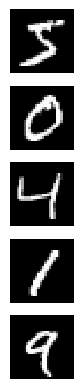

In [5]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [6]:
# Normalization betwenn -1 and 1 !!!!
quasi_mean = data.max()/2 # Max is always 255, so this works ok.
data = (data.astype(np.float32)-quasi_mean)/quasi_mean

In [7]:
# Flattening of the image vectors
data = data.reshape(data.shape[0],-1)
data.shape

(70000, 784)

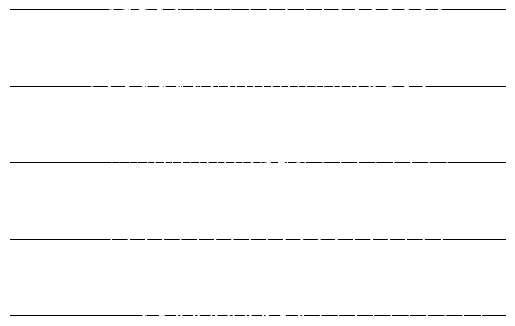

In [8]:
# Just to get the feeling, how bad this representation is...

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex].reshape(1,-1), interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [9]:
EPOCHS = 30
BATCH_SIZE = 200
HALF_BATCH = BATCH_SIZE // 2
BATCH_NUM = (data.shape[0] // BATCH_SIZE)
if data.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1
Z_DIM = 100


### Model parameters

In [10]:
GENERATOR_L1_DIM = 256
GENERATOR_L2_DIM = 512
GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 512
DISCRIMINATOR_L2_DIM = 256

LEAKY_ALPHA = 0.2

## Model building

In [11]:
import tensorflow as tf
# Some empirically set values. 
# It might well be worth experimenting with newer optimizers / settings

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, beta_1=0.5)

### Generator

In [12]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model

In [13]:
### Define the generator!
#########################

# We use FUNCTIONAL API!

# The generator always gets a noise vector as input
noise_input = Input(shape=(Z_DIM,))

# Define the first layer of the fully connected network, without activation!
# Use the parameters defined with capital letter constants in the cells above for node counts!
g_layer_1 = Dense(GENERATOR_L1_DIM)(noise_input)
# Define a non-linearioty, namely leaky relu on this layer!
# We use LeakyReLU for avoiding sparsity - other options are viable also, just not normal relu
# Use the alpha value defined in constants above!
g_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_1)
# You can do this as one layer, but now we do it in two. Does not matter.

# Repeat the process two more times!
g_layer_2 = Dense(GENERATOR_L2_DIM)(g_layer_1_nonlin)
g_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_2)

g_layer_3 = Dense(GENERATOR_L3_DIM)(g_layer_2_nonlin)
g_layer_3_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_3)

# The output of the generator is a flattened image
# Remeber, we normalized everything between -1 and +1, so what is a nice nonlinearity, bounded between
# -1 and 1? 
# Use that one as an activation for the final fully connected layer!
g_output_layer = Dense(data.shape[1], activation='tanh')(g_layer_3_nonlin)

# Please instantiate the model!
generator = Model(inputs=noise_input, outputs=g_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
# Think about this carefully, please!

### Discriminator

In [14]:
### Define the discriminator!
#############################

# We still use FUNCTIONAL API!

# The discriminator always gets (flattened) images as inputs
# Where can you find the flattened dimensions? 
# Please use a variable or property, not a hand "baked in" constant.
# That will mess up your life if the data changes...
image_input = Input(shape=(data.shape[1]))

# Following the design pattern from above, please implement two layers with nonlinearities!
d_layer_1 = Dense(DISCRIMINATOR_L1_DIM)(image_input)
d_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_1)

d_layer_2 = Dense(DISCRIMINATOR_L2_DIM)(d_layer_1_nonlin)
d_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_2)

# Please implement the output layer!
# The output of the discriminator is a single binary decision, 
# so one use an appropriate activation and dimensionality!
d_output_layer = Dense(1, activation='sigmoid')(d_layer_2_nonlin)

# Please instantiate the model!
discriminator = Model(inputs=image_input, outputs=d_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

### Joint model

In [15]:
### Define the GAN itself!
##########################


# STOP!!!!!!
# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = False

# Remove this .... if you understand, why the above line is here!

# What is the input for the whole GAN?
# Think about the case, when the generator generates, the discriminator only discriminates it's output!
gan_input = Input(shape=(Z_DIM,))

# Use the generator as a function on the input!
generated_image = generator(gan_input)
# Use the discriminator as a function on the fake images!
gan_output = discriminator(generated_image)

# Instantiate the joint model, appropriate input and output!
joint_model = Model(inputs=gan_input, outputs=gan_output)

# Please think about, why it can be true, that for the joint model a binary decision is still adequate!
joint_model.compile(loss='binary_crossentropy', optimizer=optimizer)
# Maybe it will get clear below in the training loop...

## Helper functions for visualization

In [16]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    generated_images = generator.predict(input_noise)
    generated_images = generated_images.reshape(example_count, 28, 28)
    
    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  0%|          | 1/350 [00:00<02:51,  2.04it/s]

4/4 [==============================] - 0s 1ms/step


  1%|          | 3/350 [00:00<00:59,  5.88it/s]

4/4 [==============================] - 0s 1ms/step


  1%|▏         | 5/350 [00:00<00:38,  9.00it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 7/350 [00:00<00:30, 11.31it/s]

4/4 [==============================] - 0s 1ms/step


  3%|▎         | 9/350 [00:00<00:26, 13.07it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 11/350 [00:01<00:23, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▎         | 13/350 [00:01<00:21, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 15/350 [00:01<00:20, 16.38it/s]

4/4 [==============================] - 0s 1ms/step


  5%|▍         | 17/350 [00:01<00:19, 16.77it/s]

4/4 [==============================] - 0s 1ms/step


  5%|▌         | 19/350 [00:01<00:19, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 21/350 [00:01<00:18, 17.71it/s]

4/4 [==============================] - 0s 1ms/step


  7%|▋         | 23/350 [00:01<00:18, 17.84it/s]

4/4 [==============================] - 0s 1ms/step


  7%|▋         | 25/350 [00:01<00:18, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 27/350 [00:01<00:18, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 29/350 [00:02<00:19, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 31/350 [00:02<00:19, 16.38it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 33/350 [00:02<00:19, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 35/350 [00:02<00:20, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 37/350 [00:02<00:20, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 39/350 [00:02<00:19, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 41/350 [00:02<00:19, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 43/350 [00:02<00:19, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 45/350 [00:03<00:19, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 47/350 [00:03<00:19, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 49/350 [00:03<00:19, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 51/350 [00:03<00:19, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 53/350 [00:03<00:18, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 55/350 [00:03<00:18, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▋        | 57/350 [00:03<00:19, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 59/350 [00:04<00:22, 13.07it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 61/350 [00:04<00:21, 13.42it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 63/350 [00:04<00:20, 14.00it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▊        | 65/350 [00:04<00:20, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 67/350 [00:04<00:19, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 20%|█▉        | 69/350 [00:04<00:19, 14.62it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 71/350 [00:04<00:21, 13.25it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 73/350 [00:05<00:19, 14.08it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██▏       | 75/350 [00:05<00:19, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 77/350 [00:05<00:22, 11.94it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 79/350 [00:05<00:21, 12.76it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 81/350 [00:05<00:19, 13.51it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▎       | 83/350 [00:05<00:20, 12.79it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 85/350 [00:05<00:19, 13.68it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 87/350 [00:06<00:18, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 89/350 [00:06<00:18, 14.26it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 91/350 [00:06<00:18, 13.76it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 93/350 [00:06<00:17, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 95/350 [00:06<00:17, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 97/350 [00:06<00:16, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 99/350 [00:06<00:16, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 101/350 [00:07<00:16, 15.32it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 103/350 [00:07<00:17, 14.10it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 105/350 [00:07<00:16, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 107/350 [00:07<00:16, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 109/350 [00:07<00:16, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 111/350 [00:07<00:17, 14.02it/s]

4/4 [==============================] - 0s 1ms/step


 32%|███▏      | 113/350 [00:07<00:16, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 115/350 [00:08<00:15, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 117/350 [00:08<00:15, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 119/350 [00:08<00:15, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 121/350 [00:08<00:15, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 123/350 [00:08<00:15, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 125/350 [00:08<00:15, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▋      | 127/350 [00:08<00:14, 15.47it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 129/350 [00:08<00:14, 14.83it/s]

4/4 [==============================] - 0s 1ms/step


 37%|███▋      | 131/350 [00:09<00:14, 15.51it/s]

4/4 [==============================] - 0s 1ms/step


 38%|███▊      | 133/350 [00:09<00:13, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▊      | 135/350 [00:09<00:13, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 137/350 [00:09<00:14, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 40%|███▉      | 139/350 [00:09<00:14, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 141/350 [00:09<00:13, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 143/350 [00:09<00:14, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████▏     | 145/350 [00:10<00:14, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 147/350 [00:10<00:14, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 149/350 [00:10<00:13, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 151/350 [00:10<00:15, 13.06it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▎     | 153/350 [00:10<00:14, 13.89it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 155/350 [00:10<00:13, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 157/350 [00:10<00:13, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 159/350 [00:11<00:13, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 161/350 [00:11<00:13, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 163/350 [00:11<00:12, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 165/350 [00:11<00:12, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 167/350 [00:11<00:12, 14.64it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 169/350 [00:11<00:13, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 171/350 [00:11<00:12, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 173/350 [00:11<00:12, 14.74it/s]

4/4 [==============================] - 0s 1ms/step


 50%|█████     | 175/350 [00:12<00:11, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 177/350 [00:12<00:11, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 179/350 [00:12<00:11, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 181/350 [00:12<00:10, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 183/350 [00:12<00:10, 15.97it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 185/350 [00:12<00:11, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 187/350 [00:12<00:10, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 189/350 [00:13<00:10, 15.10it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 191/350 [00:13<00:11, 13.81it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 193/350 [00:13<00:11, 14.06it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 195/350 [00:13<00:10, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 197/350 [00:13<00:10, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 199/350 [00:13<00:09, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 201/350 [00:13<00:09, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 203/350 [00:13<00:08, 16.43it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▊    | 205/350 [00:14<00:08, 16.81it/s]

4/4 [==============================] - 0s 1ms/step


 59%|█████▉    | 207/350 [00:14<00:08, 17.21it/s]

4/4 [==============================] - 0s 1ms/step


 60%|█████▉    | 209/350 [00:14<00:08, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 211/350 [00:14<00:07, 17.64it/s]

4/4 [==============================] - 0s 1ms/step


 61%|██████    | 213/350 [00:14<00:07, 17.81it/s]

4/4 [==============================] - 0s 1ms/step


 61%|██████▏   | 215/350 [00:14<00:07, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 217/350 [00:14<00:07, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 219/350 [00:14<00:07, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 221/350 [00:14<00:07, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▎   | 223/350 [00:15<00:07, 17.88it/s]

4/4 [==============================] - 0s 1ms/step


 64%|██████▍   | 225/350 [00:15<00:06, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 227/350 [00:15<00:07, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 229/350 [00:15<00:07, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 231/350 [00:15<00:07, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 233/350 [00:15<00:07, 16.26it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 235/350 [00:15<00:07, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 237/350 [00:15<00:07, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 239/350 [00:16<00:07, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 241/350 [00:16<00:07, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 243/350 [00:16<00:06, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 245/350 [00:16<00:06, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 247/350 [00:16<00:06, 16.35it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 249/350 [00:16<00:06, 16.60it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 251/350 [00:16<00:06, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 253/350 [00:16<00:06, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 255/350 [00:17<00:06, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 257/350 [00:17<00:06, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 259/350 [00:17<00:05, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 261/350 [00:17<00:05, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 263/350 [00:17<00:05, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 265/350 [00:17<00:05, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▋  | 267/350 [00:17<00:05, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 269/350 [00:17<00:05, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 271/350 [00:18<00:05, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 273/350 [00:18<00:05, 14.10it/s]

4/4 [==============================] - 0s 1ms/step


 79%|███████▊  | 275/350 [00:18<00:05, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 277/350 [00:18<00:04, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 279/350 [00:18<00:04, 15.93it/s]

4/4 [==============================] - 0s 1ms/step


 80%|████████  | 281/350 [00:18<00:04, 16.43it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 283/350 [00:18<00:04, 16.74it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 285/350 [00:18<00:03, 17.07it/s]

4/4 [==============================] - 0s 1ms/step


 82%|████████▏ | 287/350 [00:19<00:03, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 289/350 [00:19<00:03, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 291/350 [00:19<00:03, 17.55it/s]

4/4 [==============================] - 0s 1ms/step


 84%|████████▎ | 293/350 [00:19<00:03, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 295/350 [00:19<00:03, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 297/350 [00:19<00:03, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 299/350 [00:19<00:02, 17.40it/s]

4/4 [==============================] - 0s 1ms/step


 86%|████████▌ | 301/350 [00:19<00:02, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 303/350 [00:19<00:02, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 305/350 [00:20<00:02, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 307/350 [00:20<00:02, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 309/350 [00:20<00:02, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 311/350 [00:20<00:02, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 313/350 [00:20<00:02, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 315/350 [00:20<00:02, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 317/350 [00:20<00:02, 15.75it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 319/350 [00:21<00:01, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 321/350 [00:21<00:01, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 323/350 [00:21<00:01, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 325/350 [00:21<00:01, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 327/350 [00:21<00:01, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 329/350 [00:21<00:01, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 331/350 [00:21<00:01, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 333/350 [00:21<00:01, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 335/350 [00:22<00:00, 16.41it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▋| 337/350 [00:22<00:00, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 339/350 [00:22<00:00, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 341/350 [00:22<00:00, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 343/350 [00:22<00:00, 15.79it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▊| 345/350 [00:22<00:00, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 347/350 [00:22<00:00, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


100%|█████████▉| 349/350 [00:22<00:00, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:22<00:00, 15.23it/s]

Epoch number: 0 discriminator_loss: 0.6817004288094385 generator_loss: 0.8747841629811696
1/1 [==============================] - 0s 12ms/step


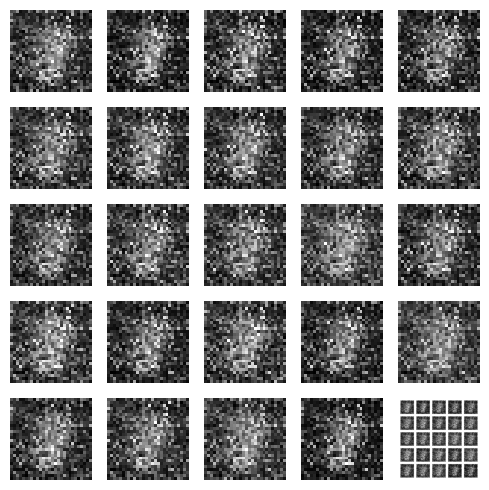

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:24, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:24, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:23, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:22, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:22, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:22, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:22, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:22, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:24, 13.58it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:23, 13.77it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:22, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:22, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:21, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:20, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:19, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:19, 16.44it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:18, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:18, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:18, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:18, 16.29it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 44/350 [00:02<00:21, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:20, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:20, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:20, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:19, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:19, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:19, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:24, 11.92it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 62/350 [00:04<00:23, 12.18it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:21, 13.03it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:20, 13.72it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:20, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:19, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:21, 12.92it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:20, 13.77it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:19, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:18, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:18, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:17, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:17, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:17, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:18, 13.86it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:18, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:17, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:17, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:17, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:16, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:16, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:16, 14.92it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 108/350 [00:07<00:17, 13.73it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:16, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:15, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:16, 13.89it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:16, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.54it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 126/350 [00:08<00:16, 13.66it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:15, 13.95it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:15, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:14, 14.90it/s]

4/4 [==============================] - 0s 1ms/step


 38%|███▊      | 134/350 [00:09<00:14, 15.21it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:15, 13.57it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:14, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:14, 14.80it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 144/350 [00:09<00:15, 13.38it/s]

4/4 [==============================] - 0s 1ms/step


 42%|████▏     | 146/350 [00:10<00:14, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:13, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:13, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:12, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:12, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:11<00:15, 11.90it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:14, 12.74it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:11<00:13, 13.58it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:13, 13.94it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:12, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:11, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:12<00:11, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:11, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:11, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 15.23it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 184/350 [00:12<00:12, 13.71it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:11, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:11, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:13<00:11, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:13<00:10, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:09, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:09, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 16.52it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:13<00:08, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:08, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:14<00:08, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:14<00:08, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:14<00:08, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:08, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:07, 17.40it/s]

4/4 [==============================] - 0s 1ms/step


 62%|██████▏   | 216/350 [00:14<00:07, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:07, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:07, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:07, 17.24it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:07, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:07, 16.39it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 16.78it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:06, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:15<00:06, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:06, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:06, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:06, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:16<00:06, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:06, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 16.88it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:05, 16.48it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:17<00:05, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:17<00:05, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:17<00:05, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:17<00:04, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:04, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:04, 16.26it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:04, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:18<00:04, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 15.94it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 16.20it/s]

4/4 [==============================] - 0s 1ms/step


 82%|████████▏ | 286/350 [00:18<00:03, 16.58it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:18<00:03, 16.71it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:19<00:03, 16.81it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 16.86it/s]

4/4 [==============================] - 0s 1ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 16.07it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:19<00:02, 16.35it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:19<00:02, 16.24it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:02, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 16.69it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 16.52it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 16.62it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:20<00:02, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:20<00:01, 16.06it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 16.33it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 16.37it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 16.60it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:21<00:01, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:21<00:01, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:21<00:00, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:22<00:00, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:22<00:00, 15.32it/s]

Epoch number: 1 discriminator_loss: 0.6450812121374266 generator_loss: 0.929414165871484
1/1 [==============================] - 0s 15ms/step


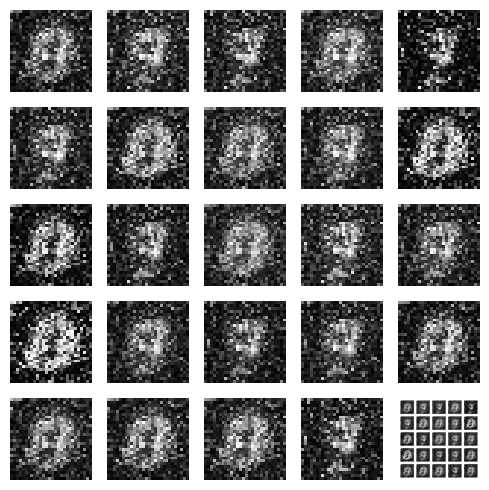

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 12ms/step


  0%|          | 1/350 [00:00<00:49,  7.03it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 3/350 [00:00<00:32, 10.83it/s]

4/4 [==============================] - 0s 2ms/step


  1%|▏         | 5/350 [00:00<00:27, 12.63it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 7/350 [00:00<00:24, 13.96it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 9/350 [00:00<00:23, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 11/350 [00:00<00:21, 15.50it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▎         | 13/350 [00:00<00:21, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 15/350 [00:01<00:21, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 17/350 [00:01<00:23, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 19/350 [00:01<00:22, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 21/350 [00:01<00:21, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 23/350 [00:01<00:21, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 25/350 [00:01<00:21, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 27/350 [00:01<00:21, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 29/350 [00:01<00:20, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 31/350 [00:02<00:20, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 33/350 [00:02<00:20, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 35/350 [00:02<00:23, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 37/350 [00:02<00:22, 13.95it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 39/350 [00:02<00:21, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 41/350 [00:02<00:21, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 43/350 [00:02<00:20, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 45/350 [00:03<00:20, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 47/350 [00:03<00:20, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 49/350 [00:03<00:19, 15.17it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 51/350 [00:03<00:21, 14.00it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 53/350 [00:03<00:20, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 55/350 [00:03<00:20, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▋        | 57/350 [00:03<00:19, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 59/350 [00:04<00:19, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 61/350 [00:04<00:19, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 63/350 [00:04<00:18, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▊        | 65/350 [00:04<00:18, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 67/350 [00:04<00:18, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 20%|█▉        | 69/350 [00:04<00:20, 13.49it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 71/350 [00:04<00:19, 14.23it/s]

4/4 [==============================] - 0s 1ms/step


 21%|██        | 73/350 [00:04<00:18, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██▏       | 75/350 [00:05<00:17, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 77/350 [00:05<00:17, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 79/350 [00:05<00:17, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 81/350 [00:05<00:17, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▎       | 83/350 [00:05<00:17, 15.43it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██▍       | 85/350 [00:05<00:19, 13.78it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 87/350 [00:05<00:18, 14.06it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 89/350 [00:06<00:18, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 91/350 [00:06<00:17, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 93/350 [00:06<00:17, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 95/350 [00:06<00:17, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 97/350 [00:06<00:16, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 99/350 [00:06<00:16, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 101/350 [00:06<00:16, 15.21it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 103/350 [00:07<00:17, 13.75it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 105/350 [00:07<00:17, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 107/350 [00:07<00:16, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 109/350 [00:07<00:16, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 111/350 [00:07<00:15, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 113/350 [00:07<00:15, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 115/350 [00:07<00:15, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 117/350 [00:07<00:15, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 119/350 [00:08<00:16, 14.03it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 121/350 [00:08<00:16, 13.73it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 123/350 [00:08<00:16, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 125/350 [00:08<00:15, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▋      | 127/350 [00:08<00:15, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 129/350 [00:08<00:15, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 131/350 [00:08<00:15, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 133/350 [00:09<00:14, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▊      | 135/350 [00:09<00:14, 14.49it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 137/350 [00:09<00:16, 13.29it/s]

4/4 [==============================] - 0s 2ms/step


 40%|███▉      | 139/350 [00:09<00:15, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 141/350 [00:09<00:14, 14.08it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 143/350 [00:09<00:14, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████▏     | 145/350 [00:09<00:13, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 147/350 [00:10<00:13, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 149/350 [00:10<00:12, 15.75it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 151/350 [00:10<00:12, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▎     | 153/350 [00:10<00:12, 16.37it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 155/350 [00:10<00:12, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 157/350 [00:10<00:12, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 159/350 [00:10<00:12, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 161/350 [00:10<00:12, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 163/350 [00:11<00:12, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 165/350 [00:11<00:11, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 167/350 [00:11<00:11, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 169/350 [00:11<00:11, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 171/350 [00:11<00:11, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 173/350 [00:11<00:11, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 175/350 [00:11<00:10, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 177/350 [00:11<00:11, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 179/350 [00:12<00:11, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 181/350 [00:12<00:10, 15.86it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 183/350 [00:12<00:10, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 185/350 [00:12<00:10, 16.39it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 187/350 [00:12<00:09, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 189/350 [00:12<00:09, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 191/350 [00:12<00:09, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 193/350 [00:12<00:09, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 195/350 [00:13<00:09, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 197/350 [00:13<00:09, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 199/350 [00:13<00:08, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 201/350 [00:13<00:08, 16.88it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 203/350 [00:13<00:09, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▊    | 205/350 [00:13<00:09, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 207/350 [00:13<00:08, 16.51it/s]

4/4 [==============================] - 0s 2ms/step


 60%|█████▉    | 209/350 [00:13<00:08, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 211/350 [00:14<00:08, 16.57it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 213/350 [00:14<00:08, 16.60it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████▏   | 215/350 [00:14<00:08, 16.52it/s]

4/4 [==============================] - 0s 1ms/step


 62%|██████▏   | 217/350 [00:14<00:07, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 219/350 [00:14<00:07, 16.79it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 221/350 [00:14<00:08, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▎   | 223/350 [00:14<00:07, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 225/350 [00:14<00:07, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 227/350 [00:14<00:07, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 229/350 [00:15<00:07, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 231/350 [00:15<00:07, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 233/350 [00:15<00:07, 16.38it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 235/350 [00:15<00:07, 16.37it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 237/350 [00:15<00:06, 16.55it/s]

4/4 [==============================] - 0s 1ms/step


 68%|██████▊   | 239/350 [00:15<00:06, 16.69it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 241/350 [00:15<00:07, 14.81it/s]

4/4 [==============================] - 0s 1ms/step


 69%|██████▉   | 243/350 [00:16<00:06, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 245/350 [00:16<00:06, 15.86it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 247/350 [00:16<00:06, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 249/350 [00:16<00:06, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 251/350 [00:16<00:06, 16.47it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 253/350 [00:16<00:06, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 255/350 [00:16<00:06, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 257/350 [00:16<00:05, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 259/350 [00:17<00:06, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 261/350 [00:17<00:05, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 263/350 [00:17<00:05, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 265/350 [00:17<00:05, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▋  | 267/350 [00:17<00:06, 12.54it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 269/350 [00:17<00:05, 13.69it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 271/350 [00:17<00:05, 14.60it/s]

4/4 [==============================] - 0s 1ms/step


 78%|███████▊  | 273/350 [00:17<00:05, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▊  | 275/350 [00:18<00:05, 14.52it/s]

4/4 [==============================] - 0s 1ms/step


 79%|███████▉  | 277/350 [00:18<00:04, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 279/350 [00:18<00:04, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 281/350 [00:18<00:04, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 283/350 [00:18<00:04, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 285/350 [00:18<00:04, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 287/350 [00:18<00:04, 15.21it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 289/350 [00:19<00:04, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 291/350 [00:19<00:03, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▎ | 293/350 [00:19<00:03, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 295/350 [00:19<00:03, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 297/350 [00:19<00:03, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 299/350 [00:19<00:03, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 301/350 [00:19<00:03, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 303/350 [00:19<00:03, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 305/350 [00:20<00:03, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 307/350 [00:20<00:02, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 309/350 [00:20<00:02, 13.77it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 311/350 [00:20<00:02, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 313/350 [00:20<00:02, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 315/350 [00:20<00:02, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 317/350 [00:20<00:02, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 319/350 [00:21<00:02, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 321/350 [00:21<00:02, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 323/350 [00:21<00:02, 12.95it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 325/350 [00:21<00:01, 13.39it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 327/350 [00:21<00:01, 13.79it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 329/350 [00:21<00:01, 13.95it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 331/350 [00:21<00:01, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 333/350 [00:22<00:01, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 335/350 [00:22<00:01, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▋| 337/350 [00:22<00:00, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 339/350 [00:22<00:00, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 341/350 [00:22<00:00, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 343/350 [00:22<00:00, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▊| 345/350 [00:22<00:00, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 347/350 [00:23<00:00, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


100%|█████████▉| 349/350 [00:23<00:00, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:23<00:00, 15.09it/s]


Epoch number: 2 discriminator_loss: 0.6124927229114941 generator_loss: 1.0589094511100223
1/1 [==============================] - 0s 11ms/step


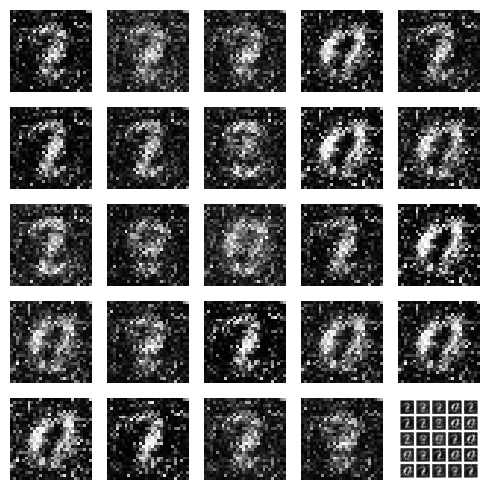

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  0%|          | 1/350 [00:00<00:48,  7.26it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 3/350 [00:00<00:29, 11.78it/s]

4/4 [==============================] - 0s 2ms/step


  1%|▏         | 5/350 [00:00<00:24, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 7/350 [00:00<00:22, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 9/350 [00:00<00:21, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 11/350 [00:00<00:22, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▎         | 13/350 [00:00<00:22, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 15/350 [00:01<00:22, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 17/350 [00:01<00:22, 14.89it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 19/350 [00:01<00:23, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 21/350 [00:01<00:22, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 23/350 [00:01<00:22, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 25/350 [00:01<00:21, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 27/350 [00:01<00:21, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 29/350 [00:01<00:20, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 31/350 [00:02<00:21, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 33/350 [00:02<00:21, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 35/350 [00:02<00:21, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 37/350 [00:02<00:21, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 39/350 [00:02<00:20, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 41/350 [00:02<00:19, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 43/350 [00:02<00:22, 13.90it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 45/350 [00:03<00:21, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 47/350 [00:03<00:20, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 49/350 [00:03<00:20, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 51/350 [00:03<00:20, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 53/350 [00:03<00:20, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 55/350 [00:03<00:19, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▋        | 57/350 [00:03<00:18, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 59/350 [00:03<00:18, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 61/350 [00:04<00:17, 16.53it/s]

4/4 [==============================] - 0s 1ms/step


 18%|█▊        | 63/350 [00:04<00:17, 16.64it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▊        | 65/350 [00:04<00:17, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 67/350 [00:04<00:18, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 20%|█▉        | 69/350 [00:04<00:18, 14.98it/s]

4/4 [==============================] - 0s 1ms/step


 20%|██        | 71/350 [00:04<00:18, 14.89it/s]

4/4 [==============================] - 0s 1ms/step


 21%|██        | 73/350 [00:04<00:17, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██▏       | 75/350 [00:04<00:17, 15.78it/s]

4/4 [==============================] - 0s 1ms/step


 22%|██▏       | 77/350 [00:05<00:18, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 79/350 [00:05<00:17, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 81/350 [00:05<00:17, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▎       | 83/350 [00:05<00:17, 15.19it/s]

4/4 [==============================] - 0s 1ms/step


 24%|██▍       | 85/350 [00:05<00:16, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 87/350 [00:05<00:16, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 89/350 [00:05<00:16, 16.24it/s]

4/4 [==============================] - 0s 1ms/step


 26%|██▌       | 91/350 [00:06<00:15, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 93/350 [00:06<00:15, 16.57it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 95/350 [00:06<00:15, 16.86it/s]

4/4 [==============================] - 0s 1ms/step


 28%|██▊       | 97/350 [00:06<00:14, 16.97it/s]

4/4 [==============================] - 0s 1ms/step


 28%|██▊       | 99/350 [00:06<00:14, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 101/350 [00:06<00:14, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 103/350 [00:06<00:14, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 105/350 [00:06<00:14, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 107/350 [00:06<00:14, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 109/350 [00:07<00:14, 16.73it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 111/350 [00:07<00:14, 16.15it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 113/350 [00:07<00:15, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 115/350 [00:07<00:15, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 117/350 [00:07<00:14, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 119/350 [00:07<00:14, 16.01it/s]

4/4 [==============================] - 0s 1ms/step


 35%|███▍      | 121/350 [00:07<00:13, 16.55it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 123/350 [00:07<00:13, 16.68it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 125/350 [00:08<00:13, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▋      | 127/350 [00:08<00:12, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 129/350 [00:08<00:12, 17.24it/s]

4/4 [==============================] - 0s 1ms/step


 37%|███▋      | 131/350 [00:08<00:12, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 133/350 [00:08<00:12, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▊      | 135/350 [00:08<00:12, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 137/350 [00:08<00:12, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 40%|███▉      | 139/350 [00:08<00:12, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 141/350 [00:08<00:12, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 143/350 [00:09<00:12, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████▏     | 145/350 [00:09<00:12, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 147/350 [00:09<00:13, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 149/350 [00:09<00:12, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 151/350 [00:09<00:13, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▎     | 153/350 [00:09<00:12, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 155/350 [00:09<00:12, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 157/350 [00:10<00:12, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 159/350 [00:10<00:12, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 161/350 [00:10<00:11, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 163/350 [00:10<00:11, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 165/350 [00:10<00:11, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 167/350 [00:10<00:11, 16.61it/s]

4/4 [==============================] - 0s 1ms/step


 48%|████▊     | 169/350 [00:10<00:10, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 171/350 [00:10<00:10, 17.13it/s]

4/4 [==============================] - 0s 1ms/step


 49%|████▉     | 173/350 [00:10<00:10, 17.40it/s]

4/4 [==============================] - 0s 1ms/step


 50%|█████     | 175/350 [00:11<00:10, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 177/350 [00:11<00:09, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 179/350 [00:11<00:09, 17.38it/s]

4/4 [==============================] - 0s 1ms/step


 52%|█████▏    | 181/350 [00:11<00:09, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 183/350 [00:11<00:09, 17.30it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 185/350 [00:11<00:09, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 187/350 [00:11<00:09, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 189/350 [00:11<00:09, 16.39it/s]

4/4 [==============================] - 0s 1ms/step


 55%|█████▍    | 191/350 [00:12<00:09, 16.09it/s]

4/4 [==============================] - 0s 1ms/step


 55%|█████▌    | 193/350 [00:12<00:09, 16.61it/s]

4/4 [==============================] - 0s 1ms/step


 56%|█████▌    | 195/350 [00:12<00:09, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 197/350 [00:12<00:08, 17.09it/s]

4/4 [==============================] - 0s 1ms/step


 57%|█████▋    | 199/350 [00:12<00:08, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 201/350 [00:12<00:08, 17.32it/s]

4/4 [==============================] - 0s 1ms/step


 58%|█████▊    | 203/350 [00:12<00:08, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▊    | 205/350 [00:12<00:08, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 207/350 [00:12<00:08, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 60%|█████▉    | 209/350 [00:13<00:08, 17.49it/s]

4/4 [==============================] - 0s 1ms/step


 60%|██████    | 211/350 [00:13<00:08, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 213/350 [00:13<00:08, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████▏   | 215/350 [00:13<00:07, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 217/350 [00:13<00:07, 17.39it/s]

4/4 [==============================] - 0s 1ms/step


 63%|██████▎   | 219/350 [00:13<00:07, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 221/350 [00:13<00:07, 17.39it/s]

4/4 [==============================] - 0s 1ms/step


 64%|██████▎   | 223/350 [00:13<00:07, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 225/350 [00:13<00:07, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 227/350 [00:14<00:07, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 229/350 [00:14<00:07, 16.03it/s]

4/4 [==============================] - 0s 1ms/step


 66%|██████▌   | 231/350 [00:14<00:07, 16.33it/s]

4/4 [==============================] - 0s 1ms/step


 67%|██████▋   | 233/350 [00:14<00:07, 16.71it/s]

4/4 [==============================] - 0s 1ms/step


 67%|██████▋   | 235/350 [00:14<00:06, 16.88it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 237/350 [00:14<00:06, 17.08it/s]

4/4 [==============================] - 0s 1ms/step


 68%|██████▊   | 239/350 [00:14<00:06, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 241/350 [00:14<00:06, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 243/350 [00:15<00:06, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 245/350 [00:15<00:05, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 247/350 [00:15<00:05, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 249/350 [00:15<00:05, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 251/350 [00:15<00:05, 17.44it/s]

4/4 [==============================] - 0s 1ms/step


 72%|███████▏  | 253/350 [00:15<00:05, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 255/350 [00:15<00:05, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 257/350 [00:15<00:05, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 259/350 [00:15<00:05, 17.37it/s]

4/4 [==============================] - 0s 1ms/step


 75%|███████▍  | 261/350 [00:16<00:05, 17.19it/s]

4/4 [==============================] - 0s 1ms/step


 75%|███████▌  | 263/350 [00:16<00:05, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 265/350 [00:16<00:04, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▋  | 267/350 [00:16<00:05, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 269/350 [00:16<00:04, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 271/350 [00:16<00:04, 16.46it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 273/350 [00:16<00:04, 16.51it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▊  | 275/350 [00:16<00:04, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 277/350 [00:17<00:04, 16.95it/s]

4/4 [==============================] - 0s 1ms/step


 80%|███████▉  | 279/350 [00:17<00:04, 17.00it/s]

4/4 [==============================] - 0s 1ms/step


 80%|████████  | 281/350 [00:17<00:04, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 283/350 [00:17<00:03, 17.30it/s]

4/4 [==============================] - 0s 1ms/step


 81%|████████▏ | 285/350 [00:17<00:03, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 287/350 [00:17<00:03, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 289/350 [00:17<00:03, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 291/350 [00:17<00:03, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▎ | 293/350 [00:17<00:03, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 295/350 [00:18<00:03, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 297/350 [00:18<00:03, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 299/350 [00:18<00:02, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 301/350 [00:18<00:03, 15.90it/s]

4/4 [==============================] - 0s 1ms/step


 87%|████████▋ | 303/350 [00:18<00:02, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 305/350 [00:18<00:02, 16.73it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 307/350 [00:18<00:02, 16.92it/s]

4/4 [==============================] - 0s 1ms/step


 88%|████████▊ | 309/350 [00:18<00:02, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 311/350 [00:19<00:02, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 313/350 [00:19<00:02, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 315/350 [00:19<00:02, 13.15it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 317/350 [00:19<00:02, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 319/350 [00:19<00:02, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 321/350 [00:19<00:01, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 323/350 [00:19<00:01, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 325/350 [00:19<00:01, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 327/350 [00:20<00:01, 15.98it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 329/350 [00:20<00:01, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 331/350 [00:20<00:01, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 333/350 [00:20<00:01, 15.79it/s]

4/4 [==============================] - 0s 1ms/step


 96%|█████████▌| 335/350 [00:20<00:00, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▋| 337/350 [00:20<00:00, 16.23it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 339/350 [00:20<00:00, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 341/350 [00:20<00:00, 16.30it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 343/350 [00:21<00:00, 16.27it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▊| 345/350 [00:21<00:00, 16.34it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 347/350 [00:21<00:00, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


100%|█████████▉| 349/350 [00:21<00:00, 15.79it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 350/350 [00:21<00:00, 16.23it/s]


Epoch number: 3 discriminator_loss: 0.634497712297099 generator_loss: 1.0310273916380746
1/1 [==============================] - 0s 11ms/step


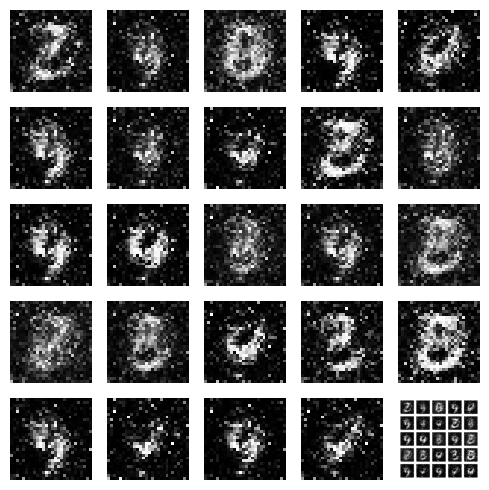

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:22, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:22, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:21, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:20, 16.66it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:20, 16.88it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:22, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:21, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:00<00:20, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:20, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:20, 16.34it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:19, 16.41it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:19, 16.43it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:19, 16.53it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:21, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:01<00:20, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:01<00:19, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:19, 16.27it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:19, 16.35it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:19, 16.41it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:18, 16.49it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 42/350 [00:02<00:20, 15.14it/s]

4/4 [==============================] - 0s 1ms/step


 13%|█▎        | 44/350 [00:02<00:19, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:02<00:18, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:02<00:18, 16.28it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:18, 16.50it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:18, 16.55it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:17, 16.52it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:19, 15.35it/s]

4/4 [==============================] - 0s 1ms/step


 17%|█▋        | 58/350 [00:03<00:18, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:03<00:18, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:03<00:17, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:03<00:17, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:17, 16.39it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:17, 16.36it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 70/350 [00:04<00:18, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:17, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:17, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:04<00:17, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:04<00:16, 16.26it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:04<00:16, 16.33it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:16, 16.44it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 84/350 [00:05<00:17, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:16, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:16, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:16, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:05<00:15, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:05<00:15, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:05<00:15, 16.52it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:15, 16.47it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:16, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:15, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:06<00:15, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:06<00:14, 16.24it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:06<00:14, 16.34it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:06<00:14, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:14, 16.41it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 116/350 [00:07<00:15, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:14, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:14, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:07<00:13, 16.41it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:07<00:13, 16.47it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:07<00:13, 16.63it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:07<00:13, 16.66it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 130/350 [00:08<00:14, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:14, 15.32it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 134/350 [00:08<00:14, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:08<00:14, 14.67it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 138/350 [00:08<00:14, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:08<00:14, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:08<00:14, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:14, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:14, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:13, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:13, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:09<00:12, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:09<00:12, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:09<00:12, 15.86it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:12, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:12, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:10<00:11, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:11, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:10<00:11, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:10<00:11, 16.48it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:10<00:10, 16.44it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 172/350 [00:10<00:11, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:10<00:11, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:11, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:10, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:10, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:11<00:10, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:11<00:10, 16.25it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:11<00:09, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:11<00:10, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:09, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:09, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:09, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:12<00:09, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:12<00:09, 16.47it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:12<00:08, 16.58it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:12<00:08, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:12<00:08, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:08, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:13<00:08, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:13<00:08, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:13<00:08, 15.81it/s]

4/4 [==============================] - 0s 1ms/step


 62%|██████▏   | 216/350 [00:13<00:08, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:13<00:08, 16.34it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:13<00:07, 16.34it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:13<00:07, 16.53it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:14<00:07, 16.37it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:14<00:07, 16.38it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:14<00:08, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:14<00:07, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:14<00:07, 15.79it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:14<00:07, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:14<00:07, 16.23it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:14<00:06, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:06, 16.64it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:15<00:06, 16.51it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:15<00:06, 16.53it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:15<00:06, 16.79it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:15<00:06, 16.52it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:15<00:05, 16.74it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:15<00:06, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:15<00:06, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:16<00:05, 15.96it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:16<00:05, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:16<00:05, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:16<00:05, 15.75it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:16<00:05, 16.07it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:16<00:05, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:16<00:05, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:16<00:05, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:05, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:17<00:04, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:17<00:04, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:17<00:04, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:17<00:04, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:17<00:04, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:17<00:04, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:04, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:18<00:04, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:18<00:03, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:18<00:03, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:18<00:03, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:18<00:03, 16.07it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:18<00:03, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:18<00:03, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:18<00:03, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:19<00:02, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:19<00:02, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:19<00:02, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:19<00:02, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:19<00:02, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:19<00:02, 15.96it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:19<00:02, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:20<00:01, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:20<00:01, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:20<00:01, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:20<00:01, 16.66it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:20<00:01, 16.36it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:20<00:01, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:20<00:01, 16.50it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:20<00:01, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:20<00:00, 16.06it/s]

4/4 [==============================] - 0s 1ms/step


 96%|█████████▌| 336/350 [00:21<00:00, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:21<00:00, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:21<00:00, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:21<00:00, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:21<00:00, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:21<00:00, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:21<00:00, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:22<00:00, 15.90it/s]

Epoch number: 4 discriminator_loss: 0.6221448983039175 generator_loss: 1.072577657869884
1/1 [==============================] - 0s 11ms/step


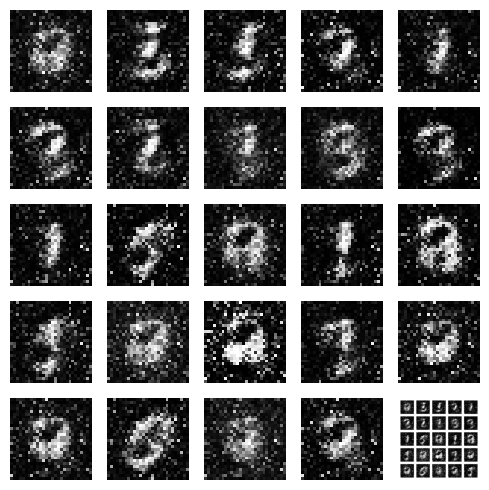

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:22, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:21, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:21, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:20, 16.36it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:20, 16.71it/s]

4/4 [==============================] - 0s 1ms/step


  3%|▎         | 12/350 [00:00<00:20, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:20, 16.10it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 16/350 [00:01<00:25, 13.35it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:24, 13.63it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:23, 13.75it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:21, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:21, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:21, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:01<00:21, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:21, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:20, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:19, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:19, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:18, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:18, 16.55it/s]

4/4 [==============================] - 0s 1ms/step


 13%|█▎        | 44/350 [00:02<00:18, 16.59it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 46/350 [00:02<00:19, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:19, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:18, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:19, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:19, 15.22it/s]

4/4 [==============================] - 0s 1ms/step


 16%|█▌        | 56/350 [00:03<00:18, 15.72it/s]

4/4 [==============================] - 0s 1ms/step


 17%|█▋        | 58/350 [00:03<00:17, 16.25it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:03<00:17, 16.36it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:03<00:17, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:17, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:18, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:18, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:17, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:17, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:17, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:04<00:19, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:17, 15.03it/s]

4/4 [==============================] - 0s 1ms/step


 25%|██▌       | 88/350 [00:05<00:16, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:16, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:05<00:16, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:15, 16.36it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:15, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:15, 16.47it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:15, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:14, 16.57it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:14, 16.66it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:06<00:16, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:06<00:15, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:15, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:14, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:14, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:15, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:07<00:14, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:07<00:14, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:14, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:14, 15.66it/s]

4/4 [==============================] - 0s 1ms/step


 37%|███▋      | 130/350 [00:08<00:13, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:13, 16.36it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:08<00:13, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:08<00:15, 13.62it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:08<00:14, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:14, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:13, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:13, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:13, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:09<00:12, 15.80it/s]

4/4 [==============================] - 0s 1ms/step


 44%|████▍     | 154/350 [00:09<00:12, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 16.10it/s]

4/4 [==============================] - 0s 1ms/step


 45%|████▌     | 158/350 [00:10<00:11, 16.15it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:11, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:10<00:11, 16.39it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:11, 16.72it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:10<00:10, 16.87it/s]

4/4 [==============================] - 0s 1ms/step


 48%|████▊     | 168/350 [00:10<00:10, 16.96it/s]

4/4 [==============================] - 0s 1ms/step


 49%|████▊     | 170/350 [00:10<00:10, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:10<00:10, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:10, 17.07it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 176/350 [00:11<00:11, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:10, 16.15it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:10, 16.36it/s]

4/4 [==============================] - 0s 1ms/step


 52%|█████▏    | 182/350 [00:11<00:10, 16.71it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:11<00:09, 16.73it/s]

4/4 [==============================] - 0s 1ms/step


 53%|█████▎    | 186/350 [00:11<00:09, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:11<00:09, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:09, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:09, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:09, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:09, 16.38it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:12<00:09, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:12<00:09, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:12<00:09, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:12<00:09, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:08, 15.95it/s]

4/4 [==============================] - 0s 1ms/step


 60%|██████    | 210/350 [00:13<00:08, 16.28it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:13<00:08, 16.46it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 214/350 [00:13<00:09, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:13<00:08, 15.14it/s]

4/4 [==============================] - 0s 1ms/step


 62%|██████▏   | 218/350 [00:13<00:08, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:13<00:08, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.77it/s]

4/4 [==============================] - 0s 1ms/step


 64%|██████▍   | 224/350 [00:14<00:07, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:14<00:07, 16.13it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:14<00:07, 16.27it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:14<00:07, 16.26it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:14<00:07, 16.43it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:14<00:07, 16.41it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:14<00:07, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:07, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:07, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:15<00:06, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:15<00:06, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:15<00:07, 13.81it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:15<00:07, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:15<00:06, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:06, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:16<00:06, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:16<00:06, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:16<00:06, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:16<00:05, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:16<00:05, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:04, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:17<00:04, 16.14it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:17<00:04, 16.28it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:17<00:04, 16.23it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:17<00:04, 16.48it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:17<00:04, 16.60it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:04, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:18<00:04, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:18<00:03, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:18<00:03, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:18<00:03, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:18<00:03, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:19<00:03, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:19<00:02, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:19<00:02, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:19<00:02, 16.02it/s]

4/4 [==============================] - 0s 1ms/step


 89%|████████▊ | 310/350 [00:19<00:02, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:19<00:02, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 16.35it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 16.47it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:20<00:01, 16.03it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 320/350 [00:20<00:02, 13.85it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:20<00:02, 13.99it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:20<00:01, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:20<00:01, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:20<00:01, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:21<00:01, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:21<00:01, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:21<00:00, 15.95it/s]

4/4 [==============================] - 0s 1ms/step


 97%|█████████▋| 338/350 [00:21<00:00, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:21<00:00, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:21<00:00, 16.37it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:21<00:00, 16.47it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 16.37it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:22<00:00, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:22<00:00, 15.67it/s]

Epoch number: 5 discriminator_loss: 0.618793496787548 generator_loss: 1.0720475598743984
1/1 [==============================] - 0s 13ms/step


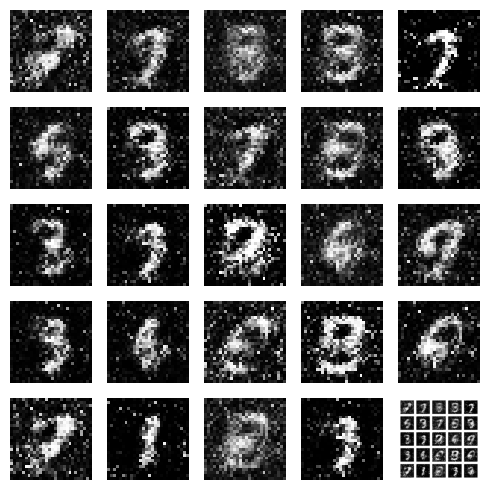

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  0%|          | 1/350 [00:00<00:39,  8.80it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 2/350 [00:00<00:39,  8.89it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:28, 11.93it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:26, 13.13it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:24, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:23, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:23, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:01<00:23, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:22, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:22, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:21, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:21, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:21, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:20, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:20, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:19, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:19, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:21, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:21, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:20, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:19, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:02<00:19, 15.79it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:19, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:20, 15.03it/s]

4/4 [==============================] - 0s 1ms/step


 14%|█▍        | 50/350 [00:03<00:19, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:19, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:19, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:18, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:18, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:18, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:18, 15.75it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:17, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:17, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:17, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:17, 15.84it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 72/350 [00:04<00:19, 14.06it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:19, 13.99it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:19, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:18, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:17, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:16, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:16, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:17, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:17, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:17, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:17, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:17, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:17, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:17, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:16, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:16, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:16, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:15, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:15, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 15.57it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 116/350 [00:07<00:15, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:15, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:15, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:14, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:14, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:14, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:14, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:13, 15.90it/s]

4/4 [==============================] - 0s 1ms/step


 38%|███▊      | 132/350 [00:08<00:13, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:08<00:13, 16.14it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:13, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:13, 15.26it/s]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 140/350 [00:09<00:14, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:14, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:13, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:13, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:13, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:12, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:12, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:13, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:10<00:12, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:12, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:11, 15.52it/s]

4/4 [==============================] - 0s 1ms/step


 48%|████▊     | 168/350 [00:11<00:11, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:11, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:11, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:10, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:10, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:10, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:10, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:10, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:10, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 15.75it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:10, 15.79it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:09, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:09, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:09, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.85it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 202/350 [00:13<00:10, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:13<00:09, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:13<00:08, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:08, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:08, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:08, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:14<00:07, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:14<00:07, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:14<00:07, 16.28it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 16.28it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:07, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:07, 15.18it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 242/350 [00:15<00:07, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:07, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 15.39it/s]

4/4 [==============================] - 0s 1ms/step


 71%|███████   | 248/350 [00:16<00:06, 15.85it/s]

4/4 [==============================] - 0s 1ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:05, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:05, 16.43it/s]

4/4 [==============================] - 0s 1ms/step


 73%|███████▎  | 256/350 [00:16<00:05, 16.44it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:16<00:05, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:16<00:05, 15.97it/s]

4/4 [==============================] - 0s 1ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 16.24it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 16.33it/s]

4/4 [==============================] - 0s 1ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:04, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:17<00:04, 16.13it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:04, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:18<00:04, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:18<00:04, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 14.56it/s]

4/4 [==============================] - 0s 1ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:19<00:03, 15.21it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:19<00:02, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:19<00:02, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 15.92it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:20<00:01, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:20<00:01, 16.44it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:20<00:01, 16.61it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 16.63it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 16.73it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:21<00:01, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:21<00:00, 16.74it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:21<00:00, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:21<00:00, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 16.72it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 16.69it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 16.81it/s]

4/4 [==============================] - 0s 1ms/step


 99%|█████████▉| 348/350 [00:22<00:00, 16.78it/s]

4/4 [==============================] - 0s 1ms/step


100%|██████████| 350/350 [00:22<00:00, 15.42it/s]

Epoch number: 6 discriminator_loss: 0.594237853714398 generator_loss: 1.14606504712786
1/1 [==============================] - 0s 11ms/step


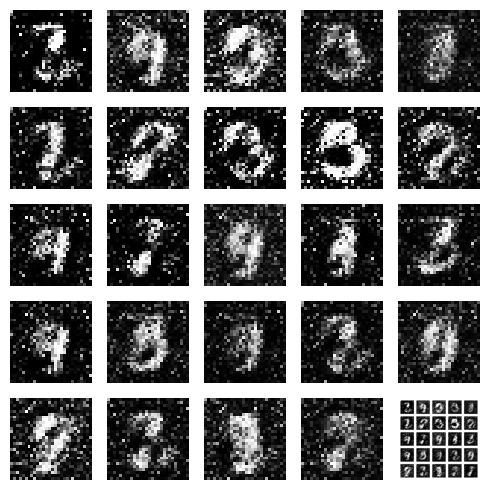

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  1%|          | 2/350 [00:00<00:22, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:22, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:21, 16.27it/s]

4/4 [==============================] - 0s 1ms/step


  2%|▏         | 8/350 [00:00<00:20, 16.59it/s]

4/4 [==============================] - 0s 1ms/step


  3%|▎         | 10/350 [00:00<00:20, 16.72it/s]

4/4 [==============================] - 0s 1ms/step


  3%|▎         | 12/350 [00:00<00:20, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:19, 16.81it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:00<00:19, 16.90it/s]

4/4 [==============================] - 0s 1ms/step


  5%|▌         | 18/350 [00:01<00:19, 16.89it/s]

4/4 [==============================] - 0s 1ms/step


  6%|▌         | 20/350 [00:01<00:19, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:19, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:19, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:19, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:19, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:01<00:19, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:01<00:18, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:18, 16.83it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 36/350 [00:02<00:20, 15.60it/s]

4/4 [==============================] - 0s 1ms/step


 11%|█         | 38/350 [00:02<00:19, 15.93it/s]

4/4 [==============================] - 0s 1ms/step


 11%|█▏        | 40/350 [00:02<00:19, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:18, 16.37it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:02<00:18, 16.59it/s]

4/4 [==============================] - 0s 1ms/step


 13%|█▎        | 46/350 [00:02<00:18, 16.39it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:02<00:18, 16.58it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:17, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:17, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:17, 16.90it/s]

4/4 [==============================] - 0s 1ms/step


 16%|█▌        | 56/350 [00:03<00:17, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:17, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:03<00:16, 17.12it/s]

4/4 [==============================] - 0s 1ms/step


 18%|█▊        | 62/350 [00:03<00:16, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:03<00:16, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:03<00:16, 17.18it/s]

4/4 [==============================] - 0s 1ms/step


 19%|█▉        | 68/350 [00:04<00:16, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:16, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:16, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:17, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:04<00:17, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:04<00:16, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:04<00:16, 16.45it/s]

4/4 [==============================] - 0s 1ms/step


 23%|██▎       | 82/350 [00:04<00:16, 16.58it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:15, 16.70it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:15, 16.77it/s]

4/4 [==============================] - 0s 1ms/step


 25%|██▌       | 88/350 [00:05<00:15, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:20, 12.47it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:05<00:19, 13.37it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:05<00:18, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:05<00:17, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:16, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:15, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:15, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:06<00:15, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:06<00:15, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:06<00:14, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:06<00:14, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:14, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:14, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:15, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:14, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:07<00:14, 15.63it/s]

4/4 [==============================] - 0s 1ms/step


 35%|███▌      | 124/350 [00:07<00:14, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:07<00:14, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:07<00:13, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:14, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:14, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:08<00:13, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:08<00:13, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:08<00:13, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:08<00:14, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:08<00:14, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:14, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:14, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:13, 14.64it/s]

4/4 [==============================] - 0s 1ms/step


 43%|████▎     | 150/350 [00:09<00:13, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:09<00:12, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:09<00:12, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:09<00:12, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:09<00:12, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:12, 15.47it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▋     | 162/350 [00:10<00:13, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:13, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:10<00:12, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:10<00:12, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:10<00:11, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:10<00:11, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:10<00:11, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:11, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:10, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:10, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:11<00:10, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:11<00:10, 16.26it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:11<00:10, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:11<00:09, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:11<00:09, 16.37it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:09, 15.86it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:10, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:10, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:12<00:09, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:12<00:09, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:12<00:09, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:12<00:09, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:12<00:09, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:13<00:09, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:13<00:09, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:13<00:09, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:13<00:09, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:13<00:08, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:13<00:08, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:14<00:08, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:14<00:07, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:14<00:07, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:14<00:07, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:14<00:07, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:14<00:07, 16.14it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:14<00:07, 16.25it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:06, 16.28it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:06, 16.28it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:15<00:06, 16.30it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:15<00:06, 16.35it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:15<00:06, 16.30it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:15<00:06, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:15<00:06, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:15<00:06, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:06, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:16<00:06, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:16<00:06, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:16<00:06, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:16<00:05, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:16<00:05, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:16<00:06, 13.42it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:06, 13.66it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 13.71it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:05, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:17<00:05, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:17<00:04, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:17<00:04, 15.33it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:17<00:04, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:04, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:18<00:04, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:18<00:04, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:18<00:03, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:18<00:03, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:18<00:03, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:19<00:03, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:19<00:02, 15.84it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 306/350 [00:19<00:02, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:19<00:02, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:19<00:02, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:19<00:02, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:20<00:02, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:20<00:01, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:20<00:01, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:20<00:01, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:20<00:01, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:21<00:01, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:21<00:01, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:21<00:01, 13.78it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:21<00:00, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:21<00:00, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:22<00:00, 15.23it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 350/350 [00:22<00:00, 15.50it/s]

Epoch number: 7 discriminator_loss: 0.5722661583764213 generator_loss: 1.1918196729251316
1/1 [==============================] - 0s 11ms/step


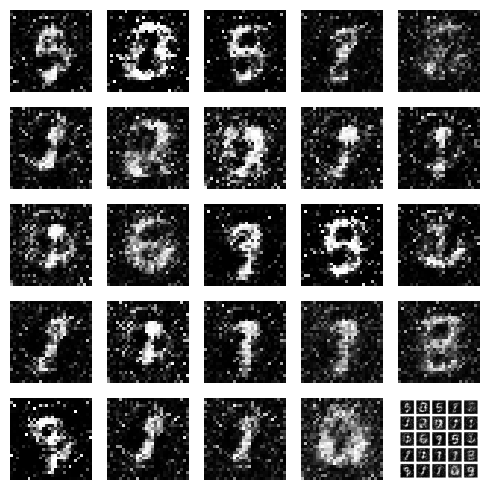

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:23, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:22, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:21, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:21, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:21, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:20, 16.15it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:20, 16.30it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:20, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:20, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:20, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:20, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:20, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:19, 16.27it/s]

4/4 [==============================] - 0s 1ms/step


  8%|▊         | 28/350 [00:01<00:19, 16.48it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:01<00:19, 16.58it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:01<00:19, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:19, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:19, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:19, 16.24it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█▏        | 40/350 [00:02<00:20, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:20, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:02<00:20, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:02<00:20, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:19, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:19, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:20, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:20, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:20, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:21, 13.87it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:03<00:20, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:19, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:19, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:18, 15.05it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:18, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:18, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:18, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:17, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:04<00:17, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:17, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:19, 13.48it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:17, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:17, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:16, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:05<00:16, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:16, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:15, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:15, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:15, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:15, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:15, 16.22it/s]

4/4 [==============================] - 0s 1ms/step


 30%|███       | 106/350 [00:06<00:15, 16.15it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:06<00:14, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:14, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:15, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:14, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:14, 16.05it/s]

4/4 [==============================] - 0s 1ms/step


 34%|███▎      | 118/350 [00:07<00:14, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:14, 16.14it/s]

4/4 [==============================] - 0s 1ms/step


 35%|███▍      | 122/350 [00:07<00:13, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:14, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:14, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:14, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:13, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:08<00:13, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:08<00:13, 15.82it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 138/350 [00:08<00:13, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:13, 15.75it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:12, 16.00it/s]

4/4 [==============================] - 0s 1ms/step


 42%|████▏     | 146/350 [00:09<00:12, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:12, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:12, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:09<00:12, 15.98it/s]

4/4 [==============================] - 0s 1ms/step


 44%|████▍     | 154/350 [00:09<00:12, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:09<00:12, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:11, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:11, 16.13it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:10<00:11, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:11, 15.90it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 166/350 [00:10<00:12, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:10<00:12, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:10<00:11, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:11, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:10, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:10, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:10, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:11<00:10, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:11<00:10, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:11<00:10, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:10, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:09, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:12, 12.18it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:12<00:11, 13.04it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:12<00:10, 13.65it/s]

4/4 [==============================] - 0s 1ms/step


 58%|█████▊    | 202/350 [00:13<00:10, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:13<00:09, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:13<00:08, 15.58it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 214/350 [00:13<00:09, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:13<00:09, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:08, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.21it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:14<00:08, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:14<00:07, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:14<00:07, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:14<00:07, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:07, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:07, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:15<00:06, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:15<00:06, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:15<00:06, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 16.01it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:06, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:16<00:06, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:16<00:05, 15.79it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:16<00:05, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:16<00:05, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:04, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:17<00:04, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:17<00:04, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:17<00:04, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:03, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:18<00:03, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:18<00:03, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:18<00:03, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:18<00:03, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 14.78it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 14.24it/s]

4/4 [==============================] - 0s 1ms/step


 86%|████████▋ | 302/350 [00:19<00:03, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:19<00:03, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:19<00:03, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:19<00:02, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:20<00:02, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:20<00:02, 13.86it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:20<00:01, 14.27it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 13.95it/s]

4/4 [==============================] - 0s 1ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:21<00:01, 13.86it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:21<00:01, 13.26it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:21<00:01, 13.70it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:22<00:00, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:22<00:00, 15.31it/s]

Epoch number: 8 discriminator_loss: 0.5570398249796459 generator_loss: 1.307247428894043
1/1 [==============================] - 0s 12ms/step


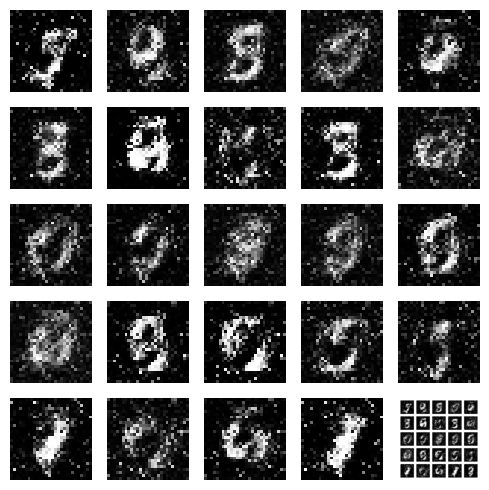

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:24, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:23, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:23, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:22, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:23, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:23, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:22, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:25, 13.18it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:24, 13.64it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:23, 14.19it/s]

4/4 [==============================] - 0s 1ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:21, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:21, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:21, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:21, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:21, 14.80it/s]

4/4 [==============================] - 0s 1ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:20, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:20, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:20, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:21, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:20, 14.86it/s]

4/4 [==============================] - 0s 1ms/step


 13%|█▎        | 46/350 [00:03<00:20, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:19, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:19, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:19, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:18, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:18, 16.15it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:18, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:03<00:17, 16.26it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:17, 16.33it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:17, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:17, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:17, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:18, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:18, 15.24it/s]

4/4 [==============================] - 0s 1ms/step


 21%|██        | 74/350 [00:04<00:17, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:17, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:17, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:16, 16.13it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:16, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:16, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:16, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:16, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:16, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:16, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:16, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:15, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:15, 16.14it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:15, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:15, 16.23it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:15, 16.25it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:06<00:15, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:15, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:15, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:14, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:14, 16.01it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:14, 16.10it/s]

4/4 [==============================] - 0s 1ms/step


 34%|███▎      | 118/350 [00:07<00:14, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:14, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:07<00:14, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:14, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:14, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:13, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:13, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:13, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:08<00:13, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:08<00:14, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:08<00:13, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:13, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:12, 15.79it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:12, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:12, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:09<00:12, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:09<00:12, 15.79it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.82it/s]

4/4 [==============================] - 0s 1ms/step


 45%|████▌     | 158/350 [00:10<00:11, 16.06it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:11, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:10<00:11, 16.08it/s]

4/4 [==============================] - 0s 1ms/step


 47%|████▋     | 164/350 [00:10<00:11, 16.25it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:10<00:11, 16.25it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:10<00:11, 16.24it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:10<00:11, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:11, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:10, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:10, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:10, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:11<00:10, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:11<00:10, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:11<00:10, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:09, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:09, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:09, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:12<00:10, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:12<00:10, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:12<00:09, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 15.67it/s]

4/4 [==============================] - 0s 1ms/step


 60%|██████    | 210/350 [00:13<00:08, 15.86it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:13<00:08, 16.08it/s]

4/4 [==============================] - 0s 1ms/step


 61%|██████    | 214/350 [00:13<00:08, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:13<00:08, 16.14it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:13<00:08, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:14<00:07, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:14<00:07, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:14<00:07, 16.25it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:14<00:07, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:14<00:07, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:14<00:07, 16.06it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:06, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:06, 16.25it/s]

4/4 [==============================] - 0s 1ms/step


 69%|██████▉   | 242/350 [00:15<00:06, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:15<00:06, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:15<00:06, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:15<00:06, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:16<00:08, 12.38it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:07, 13.16it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:07, 12.73it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:16<00:06, 13.48it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:16<00:06, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:16<00:06, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:16<00:06, 14.64it/s]

4/4 [==============================] - 0s 1ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 14.95it/s]

4/4 [==============================] - 0s 1ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:05, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:17<00:04, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:17<00:04, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:17<00:04, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:04, 15.41it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 288/350 [00:18<00:04, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:18<00:04, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:18<00:04, 13.85it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 14.55it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▋ | 302/350 [00:19<00:03, 13.18it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:19<00:03, 13.01it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:19<00:03, 13.22it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 308/350 [00:20<00:03, 13.11it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▊ | 310/350 [00:20<00:03, 13.25it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 13.63it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 13.54it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:20<00:02, 13.64it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:20<00:02, 13.54it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:02, 13.48it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 13.70it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 13.64it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 13.56it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 13.76it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:21<00:01, 13.97it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:21<00:01, 14.08it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:22<00:00, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 14.18it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 12.94it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 13.18it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:22<00:00, 13.47it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:23<00:00, 15.14it/s]

Epoch number: 9 discriminator_loss: 0.5444211737172944 generator_loss: 1.332207383428301
1/1 [==============================] - 0s 11ms/step


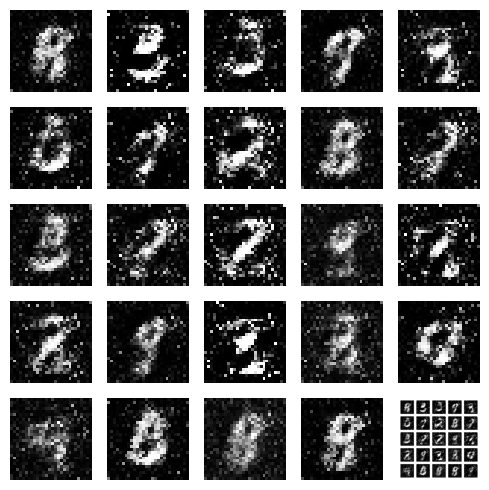

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:28, 12.34it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:26, 12.92it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:25, 13.68it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:24, 13.75it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:24, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:23, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:01<00:23, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:23, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:22, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:22, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:22, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:22, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:22, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:21, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:21, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:21, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:21, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:21, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:20, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:20, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:23, 12.86it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:22, 13.43it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:21, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:20, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:20, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:20, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:19, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:18, 15.30it/s]

4/4 [==============================] - 0s 1ms/step


 18%|█▊        | 64/350 [00:04<00:18, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:17, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:17, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:17, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:17, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:17, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:17, 15.81it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 78/350 [00:05<00:17, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:17, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:16, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:16, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:16, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:16, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:16, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:15, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:15, 16.28it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▊       | 100/350 [00:06<00:16, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:16, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:15, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:15, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:15, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:15, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:15, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:15, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:15, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:15, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:15, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:15, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:15, 13.68it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:15, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:14, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:14, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:14, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:14, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:14, 14.10it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:14, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:13, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:13, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:14, 13.14it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:14, 13.57it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:14, 13.56it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:13, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:13, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:11<00:12, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:12, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:12, 13.95it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:12, 13.94it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:12, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:12, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:11, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:11, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:11, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:10, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:13<00:10, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:10, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:09, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:13<00:09, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.17it/s]

4/4 [==============================] - 0s 1ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.22it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 208/350 [00:14<00:10, 13.55it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:14<00:09, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:09, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:09, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:08, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:08, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:15<00:08, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 15.75it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:07, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:07, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:16<00:07, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:06, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:16<00:06, 15.86it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:06, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 16.13it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:17<00:06, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:17<00:06, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:17<00:06, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:17<00:05, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:06, 12.88it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 266/350 [00:17<00:06, 13.16it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:18<00:06, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:18<00:05, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:18<00:05, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:18<00:05, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:19<00:04, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:19<00:04, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:19<00:04, 13.96it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:19<00:04, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:19<00:04, 14.28it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 292/350 [00:19<00:04, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:20<00:03, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:20<00:03, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:20<00:03, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:20<00:03, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:20<00:03, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:03, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:21<00:02, 14.08it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:21<00:02, 13.84it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:21<00:02, 12.50it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:21<00:02, 13.05it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:21<00:02, 13.11it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:02, 13.26it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 324/350 [00:22<00:01, 13.36it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:22<00:01, 13.34it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:22<00:01, 13.24it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:22<00:01, 13.53it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:22<00:01, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:22<00:01, 13.71it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 336/350 [00:22<00:01, 13.96it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 338/350 [00:23<00:00, 13.80it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:23<00:00, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:23<00:00, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:23<00:00, 14.03it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:23<00:00, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:23<00:00, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:23<00:00, 14.64it/s]

Epoch number: 10 discriminator_loss: 0.547902264382158 generator_loss: 1.3188787865638734
1/1 [==============================] - 0s 11ms/step


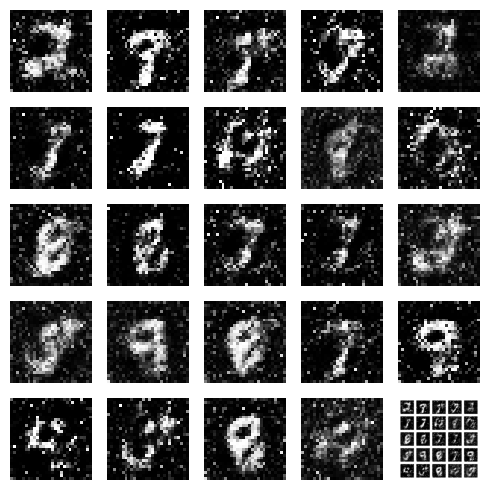

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:29, 11.63it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:27, 12.40it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:26, 12.89it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:25, 13.17it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:25, 13.26it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:28, 12.03it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:01<00:26, 12.67it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:25, 13.23it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:25, 13.17it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:25, 13.10it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:24, 13.25it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:24, 13.14it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 26/350 [00:02<00:25, 12.75it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:02<00:25, 12.83it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:24, 12.86it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:24, 13.02it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:24, 13.06it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:23, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:23, 13.33it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:03<00:22, 13.64it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:03<00:22, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:21, 13.96it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:21, 14.07it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:21, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:21, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:04<00:21, 13.73it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:04<00:21, 13.83it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:20, 14.24it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 60/350 [00:04<00:21, 13.32it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:20, 13.72it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:19, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:19, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:05<00:19, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:05<00:18, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:05<00:18, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:18, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:17, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:17, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:06<00:16, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:06<00:17, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:06<00:16, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:17, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:17, 15.05it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:16, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:16, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:16, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:07<00:15, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:07<00:15, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:15, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:15, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:15, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:15, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:15, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:14, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:14, 15.87it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:14, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:14, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:14, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:14, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:14, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:14, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:14, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:13, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:13, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:13, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:12, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:12, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:12, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:12, 15.94it/s]

4/4 [==============================] - 0s 1ms/step


 46%|████▌     | 160/350 [00:10<00:11, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:11, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:11<00:11, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:11, 15.86it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:11, 15.99it/s]

4/4 [==============================] - 0s 1ms/step


 49%|████▊     | 170/350 [00:11<00:11, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:11, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:11, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:11, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:10, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.03it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:11, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:11, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.24it/s]

4/4 [==============================] - 0s 1ms/step


 55%|█████▍    | 192/350 [00:13<00:10, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:09, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:09, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:13<00:09, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:14<00:09, 15.57it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 210/350 [00:14<00:09, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:08, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:08, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:08, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:08, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:07, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:07, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:06, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:06, 16.19it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 242/350 [00:16<00:07, 14.48it/s]

4/4 [==============================] - 0s 1ms/step


 70%|██████▉   | 244/350 [00:16<00:07, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:17<00:06, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:17<00:05, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:17<00:05, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:17<00:05, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:18<00:05, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:18<00:04, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:18<00:04, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 15.79it/s]

4/4 [==============================] - 0s 1ms/step


 81%|████████  | 284/350 [00:18<00:04, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:19<00:04, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:19<00:03, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:19<00:03, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 15.31it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▋ | 302/350 [00:20<00:03, 14.03it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:20<00:03, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:02, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:21<00:02, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:21<00:02, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:21<00:01, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:22<00:01, 15.33it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:22<00:01, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:22<00:00, 15.33it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:23<00:00, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:23<00:00, 15.08it/s]

Epoch number: 11 discriminator_loss: 0.5428550647837775 generator_loss: 1.324015075138637
1/1 [==============================] - 0s 12ms/step


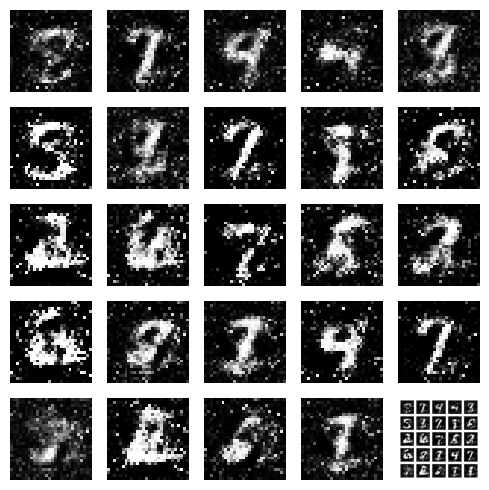

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:25, 13.60it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:24, 13.85it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:23, 14.81it/s]

4/4 [==============================] - 0s 8ms/step


  2%|▏         | 8/350 [00:00<00:27, 12.64it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:25, 13.40it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:23, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:22, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:22, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:22, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:21, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:21, 15.47it/s]

4/4 [==============================] - 0s 1ms/step


  7%|▋         | 24/350 [00:01<00:20, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:20, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:20, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:01<00:20, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:19, 15.96it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:19, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:20, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:20, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:19, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:19, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:02<00:20, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:20, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:20, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:19, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:19, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:19, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:18, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:03<00:18, 15.47it/s]

4/4 [==============================] - 0s 1ms/step


 18%|█▊        | 62/350 [00:04<00:18, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:18, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:17, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:20, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:19, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:18, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:18, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:18, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:16, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:16, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:16, 16.13it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:16, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:16, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:15, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:15, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:16, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:15, 15.68it/s]

4/4 [==============================] - 0s 19ms/step


 30%|██▉       | 104/350 [00:06<00:19, 12.70it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:18, 13.32it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:17, 13.59it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:17, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:16, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:16, 14.44it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 116/350 [00:07<00:16, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:16, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:15, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:16, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:17, 12.56it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:16, 13.28it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:16, 13.84it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:15, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:15, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:14, 14.65it/s]

4/4 [==============================] - 0s 1ms/step


 39%|███▉      | 136/350 [00:09<00:14, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:14, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:13, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:12, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:12, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:12, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:12, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:11, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:10<00:11, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:11, 16.07it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:11, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:11, 16.01it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:11, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 16.03it/s]

4/4 [==============================] - 0s 1ms/step


 50%|████▉     | 174/350 [00:11<00:10, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:10, 16.15it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:10, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:10, 16.22it/s]

4/4 [==============================] - 0s 1ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:11, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:10, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.38it/s]

4/4 [==============================] - 0s 1ms/step


 55%|█████▍    | 192/350 [00:12<00:10, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:09, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:09, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:09, 15.87it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.85it/s]

4/4 [==============================] - 0s 1ms/step


 58%|█████▊    | 202/350 [00:13<00:09, 15.86it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:13<00:08, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:13<00:09, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:08, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:08, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:08, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:14<00:08, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:14<00:07, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:07, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 15.86it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 15.86it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 238/350 [00:15<00:07, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:07, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:15<00:07, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:06, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:05, 16.01it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:16<00:05, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:16<00:05, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:17<00:05, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:04, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:17<00:04, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 15.93it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:03, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:18<00:03, 16.15it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:18<00:03, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:19<00:03, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:19<00:03, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:02, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 14.80it/s]

4/4 [==============================] - 0s 1ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 15.21it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:20<00:02, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:20<00:01, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 15.53it/s]

4/4 [==============================] - 0s 1ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:21<00:01, 15.21it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:21<00:01, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:21<00:00, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 15.71it/s]

4/4 [==============================] - 0s 1ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:22<00:00, 16.08it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 350/350 [00:22<00:00, 15.27it/s]


Epoch number: 12 discriminator_loss: 0.5822604401196753 generator_loss: 1.2192049424988882
1/1 [==============================] - 0s 12ms/step


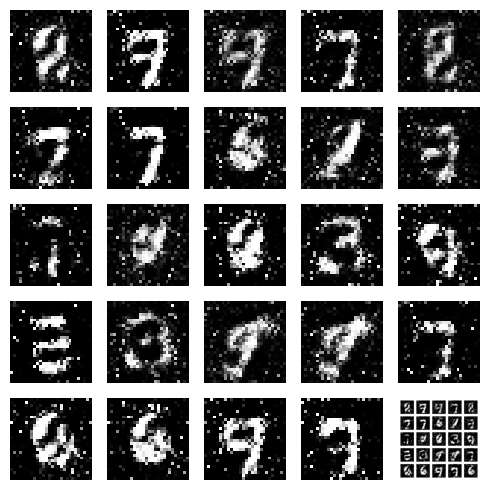

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|          | 1/350 [00:00<00:49,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 2/350 [00:00<00:42,  8.15it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:31, 11.08it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:28, 12.23it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:26, 13.01it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:25, 13.51it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:24, 13.72it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:01<00:23, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:23, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:23, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:22, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:23, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:02<00:28, 11.48it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:25, 12.54it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:23, 13.30it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:22, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:29, 10.52it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:27, 11.55it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:03<00:24, 12.48it/s]

4/4 [==============================] - 0s 1ms/step


 12%|█▏        | 42/350 [00:03<00:23, 12.99it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:22, 13.49it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:22, 13.65it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:21, 14.06it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:22, 13.19it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:04<00:21, 13.74it/s]

4/4 [==============================] - 0s 1ms/step


 16%|█▌        | 56/350 [00:04<00:20, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:20, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:19, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:19, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:18, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:18, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:05<00:19, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:05<00:19, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:05<00:19, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:19, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:19, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:19, 13.76it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:06<00:19, 13.84it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:06<00:18, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:06<00:18, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:06<00:17, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:17, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:17, 15.12it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 94/350 [00:06<00:19, 13.03it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:07<00:19, 13.14it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:07<00:18, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:07<00:17, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:07<00:17, 14.14it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 104/350 [00:07<00:17, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:18, 13.15it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:17, 13.79it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:08<00:16, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:08<00:16, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:08<00:15, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:15, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:15, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:14, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:14, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:14, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:09<00:14, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:09<00:14, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:14, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:14, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:14, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:14, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:13, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:10<00:13, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:10<00:13, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:13, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:13, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:12, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:12, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:11<00:12, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:11<00:12, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:11<00:13, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:12, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:11<00:12, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:12, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:11, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:11, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:12<00:11, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:12<00:11, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:12<00:11, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:10, 15.85it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:11, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:10, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:10, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:10, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:10, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:13<00:10, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:13<00:09, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:09, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:09, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:09, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:13<00:09, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:14<00:09, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:14<00:08, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:14<00:08, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:14<00:08, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:08, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:10, 13.39it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:09, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:15<00:09, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:15<00:08, 14.84it/s]

4/4 [==============================] - 0s 1ms/step


 63%|██████▎   | 222/350 [00:15<00:08, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:07, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:07, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:16<00:07, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:16<00:07, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:16<00:07, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:06, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:16<00:06, 15.96it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:06, 15.98it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:17<00:06, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:17<00:06, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:17<00:06, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:17<00:05, 15.73it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:17<00:05, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:17<00:05, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 15.91it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:18<00:05, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:18<00:05, 13.94it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:18<00:05, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:18<00:05, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:18<00:05, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:19<00:04, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:19<00:04, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:19<00:04, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:19<00:04, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:19<00:03, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:19<00:03, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:20<00:03, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:20<00:03, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:20<00:03, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:20<00:03, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:20<00:02, 15.79it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:02, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:21<00:02, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:21<00:02, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:21<00:02, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:21<00:02, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:21<00:01, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 14.07it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:22<00:01, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:22<00:01, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:22<00:01, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:22<00:01, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:22<00:01, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:22<00:00, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:23<00:00, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:23<00:00, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:23<00:00, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:23<00:00, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:23<00:00, 14.86it/s]

Epoch number: 13 discriminator_loss: 0.5898582639864512 generator_loss: 1.1831791499682836
1/1 [==============================] - 0s 12ms/step


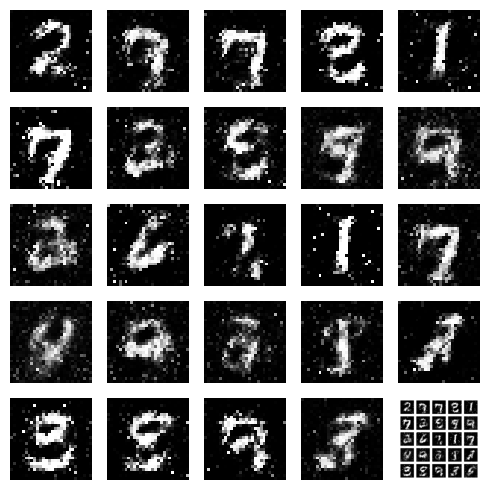

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:25, 13.75it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:24, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:22, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:22, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:22, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:22, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:21, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:21, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:21, 15.58it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▌         | 20/350 [00:01<00:23, 13.89it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:22, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:22, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:21, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:20, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:20, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:20, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:19, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:19, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:19, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:19, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:02<00:19, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:19, 15.96it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:18, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:18, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:18, 16.02it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:18, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:18, 16.00it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:18, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:03<00:18, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:18, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:18, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:18, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:17, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:17, 15.92it/s]

4/4 [==============================] - 0s 1ms/step


 21%|██        | 72/350 [00:04<00:17, 15.94it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:19, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:04<00:18, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:17, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:17, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:16, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:21, 12.03it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:19, 12.91it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:19, 13.22it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:18, 13.79it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:17, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:16, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:16, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:15, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:15, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:15, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:15, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:14, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:14, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:14, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:14, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:15, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:15, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:14, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:14, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:08<00:14, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:08<00:13, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:13, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:13, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:13, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:13, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:13, 15.02it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 152/350 [00:10<00:13, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:13, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:13, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:13, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:12, 14.94it/s]

4/4 [==============================] - 0s 1ms/step


 46%|████▋     | 162/350 [00:10<00:12, 15.05it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:12, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:10<00:12, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:11, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:12, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:11, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:11, 15.21it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 178/350 [00:11<00:12, 13.43it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:12, 13.96it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:12, 13.43it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:12, 12.92it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:12, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:11, 14.07it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:11, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:10, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:10, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:09, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.42it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 202/350 [00:13<00:09, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.58it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 15.56it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 210/350 [00:13<00:09, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:08, 15.75it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:08, 15.75it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:08, 15.68it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:08, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:14<00:08, 15.55it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 226/350 [00:15<00:07, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:07, 15.66it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 230/350 [00:15<00:08, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:08, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:07, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:07, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:16<00:06, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:06, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 15.54it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:06, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:16<00:06, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:17<00:05, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:17<00:05, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 15.77it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.80it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:18<00:04, 15.79it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:18<00:04, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 15.76it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 15.88it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 14.16it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████  | 284/350 [00:18<00:04, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:04, 15.02it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 288/350 [00:19<00:04, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:19<00:03, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:19<00:03, 15.45it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 304/350 [00:20<00:02, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:02, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 15.44it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:21<00:02, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:21<00:01, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 15.11it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 13.14it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:22<00:01, 13.80it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:22<00:01, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:22<00:00, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 14.98it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:23<00:00, 15.22it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 350/350 [00:23<00:00, 15.08it/s]

Epoch number: 14 discriminator_loss: 0.603146703839302 generator_loss: 1.1688129469326565
1/1 [==============================] - 0s 11ms/step


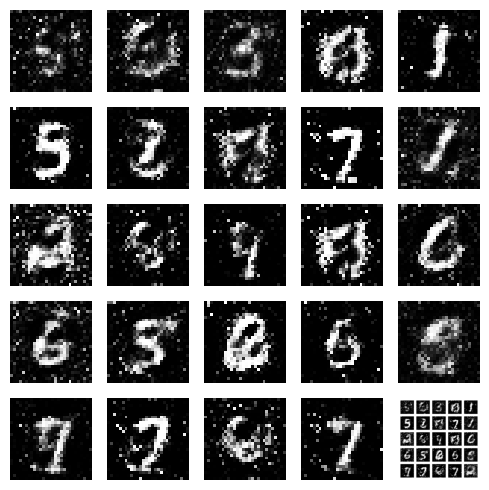

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:24, 14.23it/s]

4/4 [==============================] - 0s 1ms/step


  1%|          | 4/350 [00:00<00:23, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:22, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:22, 15.38it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 10/350 [00:00<00:22, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:21, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:21, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:21, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:21, 15.56it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:21, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:21, 15.32it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 26/350 [00:01<00:22, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:22, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:01<00:21, 14.86it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 32/350 [00:02<00:20, 15.27it/s]

4/4 [==============================] - 0s 3ms/step


 10%|▉         | 34/350 [00:02<00:20, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:20, 15.44it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 38/350 [00:02<00:20, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:19, 15.60it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 42/350 [00:02<00:19, 15.64it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:02<00:19, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:19, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:19, 15.36it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:19, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:19, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:19, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:19, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:03<00:18, 15.39it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 62/350 [00:04<00:18, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:18, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:18, 15.17it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 68/350 [00:04<00:18, 15.44it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 70/350 [00:04<00:18, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:17, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:17, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:04<00:17, 15.30it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 78/350 [00:05<00:19, 13.82it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 80/350 [00:05<00:19, 13.84it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:18, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:17, 14.89it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 88/350 [00:05<00:17, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:17, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:16, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:16, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:16, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:16, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:16, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:16, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:06<00:15, 15.34it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 108/350 [00:07<00:15, 15.28it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:16, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:15, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:15, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:14, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:14, 15.48it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 124/350 [00:08<00:14, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:14, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:15, 14.03it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 130/350 [00:08<00:15, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:14, 14.74it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 134/350 [00:08<00:14, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:08<00:14, 15.28it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 138/350 [00:09<00:13, 15.33it/s]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 140/350 [00:09<00:13, 15.04it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 142/350 [00:09<00:13, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 15.34it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 146/350 [00:09<00:13, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:13, 15.28it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 150/350 [00:09<00:13, 15.19it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:12, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.50it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 158/350 [00:10<00:12, 15.55it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 160/350 [00:10<00:12, 15.45it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▋     | 162/350 [00:10<00:12, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:11, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:10<00:11, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:11, 15.61it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▊     | 170/350 [00:11<00:11, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:11, 15.44it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 176/350 [00:11<00:12, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:11, 14.41it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████▏    | 180/350 [00:11<00:11, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:11<00:11, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:10, 15.16it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 186/350 [00:12<00:10, 15.09it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 15.07it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.12it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 192/350 [00:12<00:10, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:10, 15.31it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▌    | 196/350 [00:12<00:10, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:12, 11.89it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 200/350 [00:13<00:12, 12.28it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:13<00:11, 13.00it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:10, 13.58it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:10, 14.08it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:13<00:09, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:09, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:09, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:08, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:08, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 14.93it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 224/350 [00:14<00:08, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:08, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:08, 14.38it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 230/350 [00:15<00:08, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:08, 14.53it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:08, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:07, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:07, 14.73it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 242/350 [00:16<00:07, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:07, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 15.20it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 254/350 [00:16<00:06, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:17<00:06, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:17<00:05, 15.43it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 260/350 [00:17<00:06, 14.88it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 15.05it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.32it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 272/350 [00:18<00:05, 15.48it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 274/350 [00:18<00:04, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:05, 13.86it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 278/350 [00:18<00:05, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 14.48it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████  | 284/350 [00:18<00:04, 14.79it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 286/350 [00:19<00:04, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:19<00:04, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:19<00:04, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:20<00:03, 14.91it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▋ | 302/350 [00:20<00:03, 15.12it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 304/350 [00:20<00:03, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:02, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 15.40it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:21<00:02, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:21<00:02, 15.46it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 320/350 [00:21<00:02, 14.98it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 15.06it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 13.73it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 14.54it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 330/350 [00:22<00:01, 14.70it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 332/350 [00:22<00:01, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:22<00:01, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:22<00:00, 15.13it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 15.23it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 15.31it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:23<00:00, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:23<00:00, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:23<00:00, 14.99it/s]

Epoch number: 15 discriminator_loss: 0.6241327145269939 generator_loss: 1.0805880991050176
1/1 [==============================] - 0s 11ms/step


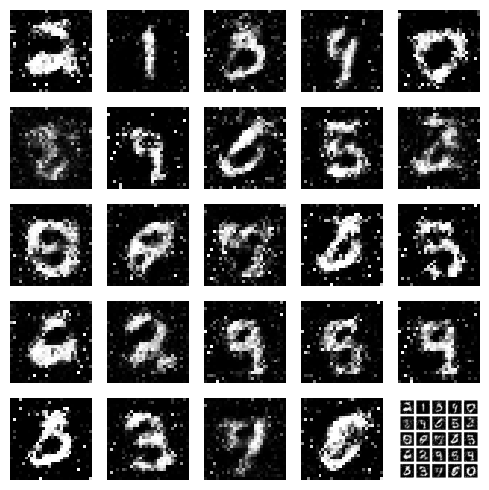

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:24, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:23, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:22, 15.03it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 8/350 [00:00<00:22, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:22, 14.88it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 12/350 [00:00<00:22, 15.04it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 14/350 [00:00<00:21, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:21, 15.32it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 18/350 [00:01<00:23, 13.87it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▌         | 20/350 [00:01<00:23, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.55it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 24/350 [00:01<00:22, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:22, 14.69it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 28/350 [00:01<00:21, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:22, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:21, 14.70it/s]

4/4 [==============================] - 0s 3ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.88it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 36/350 [00:02<00:20, 15.15it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 38/350 [00:02<00:20, 15.24it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█▏        | 40/350 [00:02<00:20, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:20, 15.19it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 44/350 [00:02<00:20, 15.21it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 46/350 [00:03<00:19, 15.35it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▎        | 48/350 [00:03<00:19, 15.37it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 50/350 [00:03<00:19, 15.49it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 52/350 [00:03<00:19, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:19, 15.26it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 56/350 [00:03<00:19, 15.44it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 58/350 [00:03<00:18, 15.48it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 60/350 [00:03<00:18, 15.62it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 62/350 [00:04<00:18, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:18, 15.83it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:20, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:19, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:18, 14.85it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 72/350 [00:04<00:18, 15.14it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 74/350 [00:04<00:17, 15.39it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 76/350 [00:05<00:17, 15.45it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 78/350 [00:05<00:17, 15.46it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.09it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.04it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 84/350 [00:05<00:17, 15.02it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▍       | 86/350 [00:05<00:17, 14.98it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 88/350 [00:05<00:17, 14.96it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 90/350 [00:05<00:17, 15.13it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▋       | 92/350 [00:06<00:16, 15.23it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 94/350 [00:06<00:16, 15.19it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 96/350 [00:06<00:16, 15.36it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 98/350 [00:06<00:16, 15.58it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▊       | 100/350 [00:06<00:16, 15.47it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 102/350 [00:06<00:16, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:16, 15.29it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 106/350 [00:07<00:16, 15.10it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 108/350 [00:07<00:16, 14.61it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.80it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 112/350 [00:07<00:15, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:17, 13.63it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 116/350 [00:07<00:16, 14.09it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 118/350 [00:07<00:16, 14.36it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.59it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.73it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.84it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 126/350 [00:08<00:15, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:14, 14.95it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 130/350 [00:08<00:14, 14.84it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 132/350 [00:08<00:14, 15.02it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 134/350 [00:08<00:14, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:14, 14.92it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 138/350 [00:09<00:14, 15.02it/s]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 140/350 [00:09<00:13, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.16it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 144/350 [00:09<00:13, 15.17it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 146/350 [00:09<00:13, 15.26it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 148/350 [00:09<00:13, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:13, 15.38it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.28it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 154/350 [00:10<00:12, 15.25it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.33it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 158/350 [00:10<00:13, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:13, 14.47it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▋     | 162/350 [00:10<00:12, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:12, 14.64it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 166/350 [00:11<00:12, 14.84it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 168/350 [00:11<00:12, 15.00it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▊     | 170/350 [00:11<00:11, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 15.17it/s]

4/4 [==============================] - 0s 3ms/step


 50%|████▉     | 174/350 [00:11<00:11, 15.27it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 176/350 [00:11<00:11, 15.38it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 178/350 [00:11<00:11, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:11, 15.35it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 182/350 [00:12<00:10, 15.37it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 184/350 [00:12<00:10, 15.39it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 186/350 [00:12<00:10, 15.45it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 15.49it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:10, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:10, 14.96it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▌    | 196/350 [00:13<00:10, 14.98it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 198/350 [00:13<00:10, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.13it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 202/350 [00:13<00:09, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.27it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.33it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:10, 13.86it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 210/350 [00:14<00:09, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:09, 14.53it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 214/350 [00:14<00:09, 14.69it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 216/350 [00:14<00:09, 14.81it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 218/350 [00:14<00:09, 14.47it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 14.69it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 14.88it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 224/350 [00:14<00:08, 14.89it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 226/350 [00:15<00:08, 14.94it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▌   | 228/350 [00:15<00:08, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 15.13it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 15.35it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 15.36it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 238/350 [00:15<00:07, 15.41it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▊   | 240/350 [00:15<00:07, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:16<00:07, 15.38it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 244/350 [00:16<00:07, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 14.88it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 248/350 [00:16<00:06, 14.95it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:08, 11.95it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:17<00:08, 11.51it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 256/350 [00:17<00:07, 12.27it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:17<00:07, 12.99it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 260/350 [00:17<00:06, 13.56it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▍  | 262/350 [00:17<00:06, 14.02it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 264/350 [00:17<00:06, 14.23it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 14.50it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 268/350 [00:18<00:05, 14.57it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 270/350 [00:18<00:05, 14.65it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 272/350 [00:18<00:05, 14.37it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 274/350 [00:18<00:05, 14.63it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 276/350 [00:18<00:05, 14.72it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 14.80it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 280/350 [00:18<00:04, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 14.90it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████  | 284/350 [00:19<00:04, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:19<00:04, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:19<00:04, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:19<00:03, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 15.35it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 15.36it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 15.39it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 298/350 [00:20<00:03, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:20<00:03, 12.70it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:20<00:03, 13.49it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 304/350 [00:20<00:03, 14.08it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 306/350 [00:20<00:03, 14.51it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 14.73it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:21<00:02, 14.91it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 314/350 [00:21<00:02, 14.97it/s]

4/4 [==============================] - 0s 3ms/step


 90%|█████████ | 316/350 [00:21<00:02, 15.07it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 318/350 [00:21<00:02, 15.08it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 320/350 [00:21<00:01, 15.23it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 15.27it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 14.72it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▎| 328/350 [00:22<00:01, 14.87it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 330/350 [00:22<00:01, 14.97it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 332/350 [00:22<00:01, 15.17it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 334/350 [00:22<00:01, 15.09it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 336/350 [00:22<00:00, 15.05it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 15.09it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:23<00:00, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:23<00:00, 15.33it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 346/350 [00:23<00:00, 15.39it/s]

4/4 [==============================] - 0s 1ms/step


 99%|█████████▉| 348/350 [00:23<00:00, 13.69it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:23<00:00, 14.85it/s]

Epoch number: 16 discriminator_loss: 0.6280994474887848 generator_loss: 1.0440512761047909
1/1 [==============================] - 0s 12ms/step


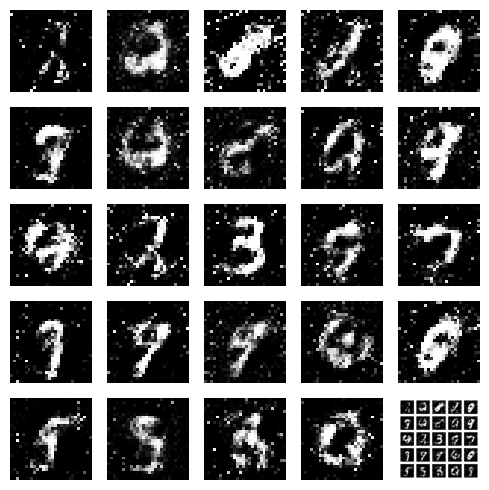

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:24, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:24, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:23, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:23, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:22, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:22, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:21, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:21, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:21, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:21, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:20, 15.69it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:20, 15.67it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 26/350 [00:01<00:20, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:20, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:01<00:20, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:20, 15.74it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:20, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:20, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:20, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:22, 13.98it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:21, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:02<00:20, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:20, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:19, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:19, 15.33it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 52/350 [00:03<00:19, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:19, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:19, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:19, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:03<00:18, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:18, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:18, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:18, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:18, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:18, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:17, 15.47it/s]

4/4 [==============================] - 0s 1ms/step


 21%|██        | 74/350 [00:04<00:18, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:04<00:17, 15.37it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 78/350 [00:05<00:17, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.22it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:18, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:17, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:17, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:17, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:17, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:16, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:16, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:16, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:16, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:16, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:16, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:15, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:15, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:15, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:14, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:14, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:14, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:14, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:14, 15.44it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 128/350 [00:08<00:15, 14.08it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 130/350 [00:08<00:15, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:15, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:08<00:14, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:08<00:14, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:13, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:13, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:13, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:12, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:13, 14.82it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 156/350 [00:10<00:13, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:12, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:12, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:10<00:12, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:12, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:10<00:11, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:11, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:11, 15.33it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:12, 13.73it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:12, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:11, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:11, 14.69it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:11, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:10, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:10, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:12<00:10, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:09, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:09, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:13<00:09, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:13<00:09, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:09, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:08, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:08, 15.41it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 218/350 [00:14<00:09, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:14<00:08, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:14<00:08, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:08, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 15.30it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:07, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:07, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:15<00:06, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:06, 15.70it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:06, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:16<00:06, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:17<00:05, 15.46it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 260/350 [00:17<00:05, 15.21it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▍  | 262/350 [00:17<00:06, 13.87it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:05, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:18<00:05, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:04, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:19<00:04, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:19<00:03, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 15.21it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:19<00:03, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:20<00:02, 15.36it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:02, 15.31it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 14.28it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:21<00:02, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:21<00:01, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:21<00:01, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:22<00:01, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:22<00:00, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:23<00:00, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:23<00:00, 15.10it/s]

Epoch number: 17 discriminator_loss: 0.6281807632957186 generator_loss: 1.06690862263952
1/1 [==============================] - 0s 13ms/step


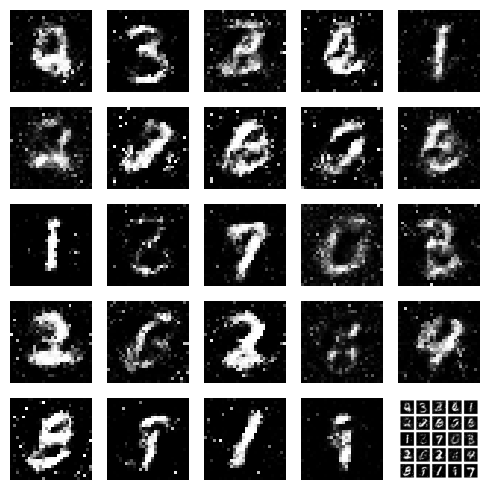

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:24, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:23, 14.80it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 6/350 [00:00<00:22, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:22, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:23, 14.56it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 12/350 [00:00<00:23, 14.65it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 14/350 [00:00<00:22, 14.77it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 16/350 [00:01<00:22, 14.79it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 18/350 [00:01<00:22, 14.94it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:21, 15.05it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 24/350 [00:01<00:21, 15.18it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 26/350 [00:01<00:21, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:21, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:20, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:20, 15.27it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.86it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 36/350 [00:02<00:21, 14.95it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 38/350 [00:02<00:20, 14.93it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 40/350 [00:02<00:22, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:21, 14.20it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 44/350 [00:02<00:21, 14.48it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 46/350 [00:03<00:20, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:20, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:19, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:19, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:19, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:19, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:18, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:19, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:18, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:18, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:18, 15.49it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 68/350 [00:04<00:18, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:18, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:17, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:17, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:17, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:17, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.34it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 84/350 [00:05<00:20, 13.12it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▍       | 86/350 [00:05<00:19, 13.57it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:18, 14.08it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:17, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:17, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:16, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:16, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:16, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 15.48it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 102/350 [00:06<00:16, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:15, 15.38it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 106/350 [00:07<00:15, 15.33it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:15, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:15, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:15, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:15, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:14, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:14, 15.67it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▍      | 122/350 [00:08<00:14, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:14, 15.52it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 126/350 [00:08<00:15, 14.00it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 128/350 [00:08<00:15, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:14, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:14, 14.87it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 134/350 [00:08<00:14, 14.61it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 136/350 [00:09<00:14, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 15.08it/s]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 140/350 [00:09<00:13, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 15.46it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 146/350 [00:09<00:13, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:13, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:12, 15.59it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:12, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:12, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:12, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:10<00:12, 15.37it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 164/350 [00:10<00:12, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:10<00:11, 15.59it/s]

4/4 [==============================] - 0s 1ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.05it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▊     | 170/350 [00:11<00:12, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:12, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:11, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:11, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:11, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:11, 15.21it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 15.26it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 184/350 [00:12<00:11, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:10, 15.05it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:10, 15.23it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 194/350 [00:12<00:10, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:10, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:09, 15.39it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:13<00:09, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.20it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.18it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:13<00:10, 13.47it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 212/350 [00:14<00:09, 13.87it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 214/350 [00:14<00:09, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:09, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:08, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.04it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.14it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 224/350 [00:14<00:08, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:08, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:07, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 15.39it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 15.01it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:07, 15.16it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▊   | 240/350 [00:15<00:07, 15.15it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 242/350 [00:16<00:07, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:07, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 15.15it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:07, 13.62it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 254/350 [00:16<00:06, 14.03it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 256/350 [00:17<00:06, 14.12it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▎  | 258/350 [00:17<00:06, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:17<00:06, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 14.93it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 15.17it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.32it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 272/350 [00:18<00:05, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:18<00:04, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:18<00:04, 15.47it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 280/350 [00:18<00:04, 15.09it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████  | 282/350 [00:18<00:04, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:19<00:04, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:19<00:04, 15.27it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 290/350 [00:19<00:03, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:04, 13.64it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:20<00:03, 14.93it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 304/350 [00:20<00:03, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:02, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 15.25it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:21<00:02, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:21<00:02, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:21<00:01, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 15.31it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 15.33it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 15.01it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:22<00:01, 15.20it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:22<00:01, 15.22it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 336/350 [00:22<00:01, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 14.18it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:23<00:00, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:23<00:00, 15.07it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 350/350 [00:23<00:00, 15.00it/s]

Epoch number: 18 discriminator_loss: 0.6385682533468519 generator_loss: 1.0230064148562295
1/1 [==============================] - 0s 11ms/step


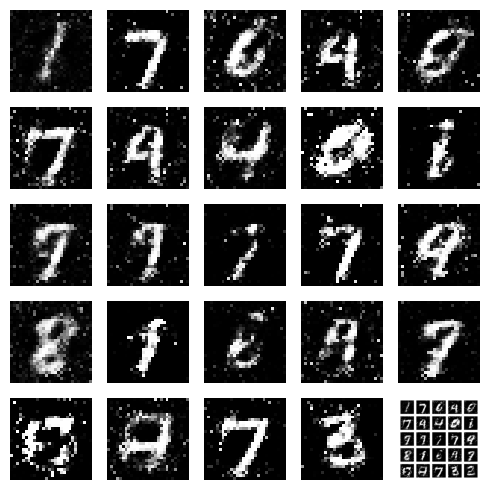

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:25, 13.58it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:25, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:23, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:23, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:22, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:22, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:22, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:22, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:22, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:21, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:21, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:25, 12.93it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:24, 13.47it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:22, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:21, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:21, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:20, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:20, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:20, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:19, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:02<00:19, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:19, 15.54it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:19, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:19, 15.32it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:19, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:19, 15.44it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:18, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:03<00:18, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:18, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:18, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:18, 15.59it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 66/350 [00:04<00:19, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:19, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:18, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:18, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:04<00:18, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:17, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:17, 15.30it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:17, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:17, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:17, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:16, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:05<00:16, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:05<00:16, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:16, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:16, 15.66it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:16, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:16, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 15.33it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:06<00:15, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:06<00:15, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:15, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:15, 15.65it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:16, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:07<00:15, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:07<00:15, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:07<00:15, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:14, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:14, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:14, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:08<00:14, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:08<00:14, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:08<00:14, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:08<00:13, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:13, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:13, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:13, 15.50it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:09<00:13, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:09<00:13, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:09<00:13, 15.07it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:09<00:13, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:12, 15.27it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:14, 13.48it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:13, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:13, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:10<00:12, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:10<00:12, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:10<00:12, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:12, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:12, 15.05it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:11, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:11, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:11<00:11, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:11<00:11, 15.53it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:11<00:10, 15.67it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:11<00:10, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:10, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:10, 15.61it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:10, 15.63it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:12<00:10, 15.65it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:12<00:10, 15.09it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:12<00:10, 15.10it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 194/350 [00:12<00:11, 14.00it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:12<00:10, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:10, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:13<00:09, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:13<00:09, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:13<00:09, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:13<00:09, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:13<00:09, 15.60it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:13<00:08, 15.72it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:08, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:08, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:14<00:08, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:14<00:08, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:14<00:08, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:14<00:08, 15.51it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:14<00:08, 15.47it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:14<00:07, 15.62it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:07, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:15<00:07, 15.71it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:15<00:07, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:15<00:07, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:15<00:07, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:15<00:08, 13.38it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:15<00:07, 13.91it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:16<00:07, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:07, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:16<00:06, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:16<00:06, 14.98it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:16<00:06, 15.24it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:16<00:06, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:16<00:06, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:16<00:06, 15.41it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:17<00:06, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:17<00:05, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:17<00:05, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:17<00:05, 15.34it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:17<00:05, 15.33it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:17<00:05, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:17<00:05, 15.58it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:17<00:05, 15.49it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:18<00:04, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:18<00:04, 15.42it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 278/350 [00:18<00:05, 13.84it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:18<00:04, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:18<00:04, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:18<00:04, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:18<00:04, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:19<00:04, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:19<00:03, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:19<00:03, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:19<00:03, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:19<00:03, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:19<00:03, 15.37it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:19<00:03, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:19<00:03, 15.42it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 304/350 [00:20<00:03, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:20<00:02, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:20<00:02, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:20<00:02, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:20<00:02, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:20<00:02, 15.52it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:20<00:02, 15.54it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 318/350 [00:21<00:02, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:21<00:02, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:21<00:01, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:21<00:01, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:21<00:01, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:21<00:01, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:21<00:01, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:21<00:01, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:22<00:01, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:22<00:00, 15.21it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:22<00:00, 15.25it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:22<00:00, 15.28it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:22<00:00, 15.40it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:22<00:00, 15.29it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:22<00:00, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:23<00:00, 15.24it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 350/350 [00:23<00:00, 15.11it/s]

Epoch number: 19 discriminator_loss: 0.6286516617877143 generator_loss: 1.0395000958442688
1/1 [==============================] - 0s 12ms/step


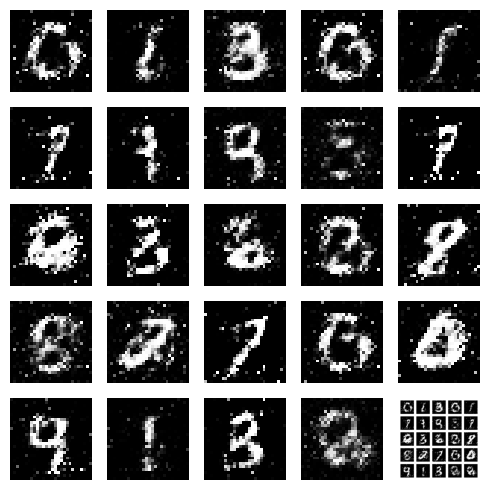

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:24, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:23, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:23, 14.80it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 8/350 [00:00<00:25, 13.24it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:24, 13.73it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:23, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:22, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:22, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:22, 15.01it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:21, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:21, 15.12it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:21, 15.16it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:20, 15.39it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:20, 15.42it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:20, 15.45it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:20, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:20, 15.48it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:26, 11.87it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:24, 12.62it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:23, 13.27it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:22, 13.48it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:21, 14.01it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:21, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:22, 13.26it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:21, 13.78it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:20, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:20, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:19, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:19, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:19, 14.48it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 66/350 [00:04<00:20, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:20, 13.59it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:20, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:05<00:19, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:19, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:18, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 14.57it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 80/350 [00:05<00:18, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:18, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:17, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:06<00:19, 13.73it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:06<00:18, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:18, 13.83it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▋       | 92/350 [00:06<00:19, 13.11it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:19, 13.32it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 96/350 [00:06<00:18, 13.50it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:18, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:07<00:17, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:07<00:17, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:17, 14.27it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 106/350 [00:07<00:17, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:16, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:16, 14.10it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:08<00:16, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:15, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:15, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:14, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:14, 15.19it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:14, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:16, 13.75it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:15, 13.72it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 134/350 [00:09<00:17, 12.58it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 136/350 [00:09<00:18, 11.56it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 138/350 [00:09<00:17, 12.29it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:16, 12.84it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 142/350 [00:10<00:15, 13.17it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:10<00:15, 13.34it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:15, 13.53it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:14, 13.91it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:13, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:13, 14.40it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 154/350 [00:10<00:15, 12.31it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 156/350 [00:11<00:16, 11.89it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:11<00:15, 12.64it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:11<00:14, 13.38it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:13, 14.02it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 164/350 [00:11<00:12, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:12, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:12<00:12, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:12<00:11, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:12<00:11, 15.15it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 176/350 [00:12<00:12, 13.76it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:12, 13.74it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████▏    | 180/350 [00:12<00:11, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:13<00:11, 14.69it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 186/350 [00:13<00:11, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:11, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:13<00:11, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:13<00:10, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:10, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:14<00:10, 15.07it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 200/350 [00:14<00:10, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:14<00:10, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:14<00:09, 14.90it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 206/350 [00:14<00:09, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:14<00:09, 14.98it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 210/350 [00:14<00:09, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:09, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:15<00:08, 15.13it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:15<00:08, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:15<00:09, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:15<00:09, 13.85it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 222/350 [00:15<00:09, 13.81it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 14.03it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:09, 13.65it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▌   | 228/350 [00:16<00:09, 13.53it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 230/350 [00:16<00:08, 13.84it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 232/350 [00:16<00:08, 13.87it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:16<00:08, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:16<00:07, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:16<00:07, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:07, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:17<00:07, 14.33it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 244/350 [00:17<00:07, 13.57it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:17<00:07, 13.94it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:17<00:07, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:17<00:06, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:17<00:06, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:17<00:06, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:18<00:06, 14.88it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▎  | 258/350 [00:18<00:06, 14.68it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 260/350 [00:18<00:06, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:18<00:07, 12.53it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:18<00:07, 12.20it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 266/350 [00:18<00:07, 11.62it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:19<00:06, 11.93it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:19<00:06, 12.28it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 272/350 [00:19<00:06, 12.43it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:19<00:06, 12.49it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:19<00:05, 12.68it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:19<00:05, 13.09it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:19<00:05, 12.80it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████  | 282/350 [00:20<00:05, 12.78it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:20<00:05, 13.17it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 286/350 [00:20<00:04, 13.28it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 288/350 [00:20<00:04, 12.66it/s]

4/4 [==============================] - 0s 7ms/step


 83%|████████▎ | 290/350 [00:20<00:05, 11.10it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 292/350 [00:21<00:05, 11.51it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:21<00:04, 12.29it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▍ | 296/350 [00:21<00:04, 12.69it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 298/350 [00:21<00:03, 13.05it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:21<00:03, 13.36it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▋ | 302/350 [00:21<00:03, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:21<00:03, 13.69it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 306/350 [00:22<00:03, 13.34it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 308/350 [00:22<00:03, 13.05it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▊ | 310/350 [00:22<00:03, 12.04it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 312/350 [00:22<00:03, 12.59it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:22<00:02, 13.13it/s]

4/4 [==============================] - 0s 3ms/step


 90%|█████████ | 316/350 [00:22<00:02, 13.58it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:22<00:02, 14.01it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:23<00:02, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:23<00:01, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:23<00:01, 14.78it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 326/350 [00:23<00:01, 12.73it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:23<00:01, 12.73it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:23<00:01, 12.88it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 332/350 [00:23<00:01, 12.79it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:24<00:01, 12.86it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 336/350 [00:24<00:01, 12.86it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:24<00:00, 13.03it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 340/350 [00:24<00:00, 13.10it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:24<00:00, 13.27it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:24<00:00, 13.31it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:25<00:00, 13.24it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:25<00:00, 13.22it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 350/350 [00:25<00:00, 13.81it/s]

Epoch number: 20 discriminator_loss: 0.6435458961980683 generator_loss: 1.0147610448087965
1/1 [==============================] - 0s 11ms/step


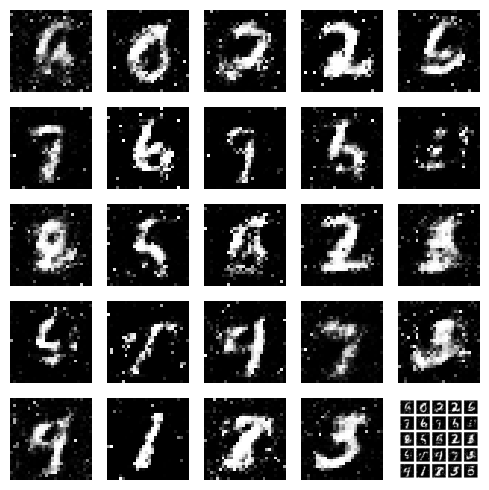

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|          | 1/350 [00:00<00:39,  8.86it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 3/350 [00:00<00:44,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


  1%|▏         | 5/350 [00:00<00:35,  9.82it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 7/350 [00:00<00:30, 11.08it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 9/350 [00:00<00:28, 11.89it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 11/350 [00:00<00:27, 12.51it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▎         | 13/350 [00:01<00:26, 12.75it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 15/350 [00:01<00:25, 13.15it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 17/350 [00:01<00:25, 13.27it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 19/350 [00:01<00:24, 13.33it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 21/350 [00:01<00:24, 13.51it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 23/350 [00:01<00:24, 13.32it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 25/350 [00:02<00:24, 13.23it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 27/350 [00:02<00:24, 13.31it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 29/350 [00:02<00:23, 13.51it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 31/350 [00:02<00:23, 13.46it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 33/350 [00:02<00:23, 13.70it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 35/350 [00:02<00:22, 13.81it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 37/350 [00:02<00:24, 12.63it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 39/350 [00:03<00:23, 13.03it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 41/350 [00:03<00:23, 13.28it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 43/350 [00:03<00:22, 13.52it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 45/350 [00:03<00:22, 13.53it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 47/350 [00:03<00:23, 13.08it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 49/350 [00:03<00:22, 13.29it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 51/350 [00:03<00:22, 13.37it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 53/350 [00:04<00:21, 13.62it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 55/350 [00:04<00:21, 13.55it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▋        | 57/350 [00:04<00:21, 13.58it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 59/350 [00:04<00:21, 13.72it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 61/350 [00:04<00:21, 13.64it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 63/350 [00:04<00:20, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▊        | 65/350 [00:04<00:20, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 67/350 [00:05<00:20, 13.96it/s]

4/4 [==============================] - 0s 2ms/step


 20%|█▉        | 69/350 [00:05<00:20, 13.50it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 71/350 [00:05<00:20, 13.63it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██        | 73/350 [00:05<00:22, 12.53it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██▏       | 75/350 [00:05<00:21, 12.63it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 77/350 [00:05<00:21, 12.86it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 79/350 [00:06<00:20, 13.09it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 81/350 [00:06<00:20, 13.08it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▎       | 83/350 [00:06<00:19, 13.37it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 85/350 [00:06<00:19, 13.51it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 87/350 [00:06<00:19, 13.60it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 89/350 [00:06<00:19, 13.70it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 91/350 [00:07<00:24, 10.69it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 93/350 [00:07<00:22, 11.67it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 95/350 [00:07<00:20, 12.48it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 97/350 [00:07<00:19, 13.06it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 99/350 [00:07<00:18, 13.46it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 101/350 [00:07<00:18, 13.80it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 103/350 [00:07<00:17, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 105/350 [00:08<00:17, 13.95it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 107/350 [00:08<00:17, 14.20it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 109/350 [00:08<00:18, 12.68it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 111/350 [00:08<00:18, 13.22it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 113/350 [00:08<00:17, 13.27it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 115/350 [00:08<00:17, 13.66it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 117/350 [00:08<00:16, 13.94it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 119/350 [00:09<00:16, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 121/350 [00:09<00:16, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 123/350 [00:09<00:15, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 125/350 [00:09<00:15, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▋      | 127/350 [00:09<00:15, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 129/350 [00:09<00:15, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 131/350 [00:09<00:14, 14.74it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 133/350 [00:10<00:15, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▊      | 135/350 [00:10<00:14, 14.63it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 137/350 [00:10<00:14, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 40%|███▉      | 139/350 [00:10<00:14, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 141/350 [00:10<00:14, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 143/350 [00:10<00:15, 13.03it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████▏     | 145/350 [00:10<00:15, 13.52it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 147/350 [00:11<00:14, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 149/350 [00:11<00:14, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 151/350 [00:11<00:13, 14.39it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▎     | 153/350 [00:11<00:13, 14.44it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 155/350 [00:11<00:13, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 157/350 [00:11<00:13, 14.07it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 159/350 [00:11<00:13, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 161/350 [00:11<00:13, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 163/350 [00:12<00:13, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 165/350 [00:12<00:12, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 167/350 [00:12<00:12, 14.60it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 169/350 [00:12<00:12, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 171/350 [00:12<00:12, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 173/350 [00:12<00:12, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 175/350 [00:12<00:12, 14.52it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 177/350 [00:13<00:14, 12.29it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 179/350 [00:13<00:13, 12.62it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 181/350 [00:13<00:12, 13.05it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 183/350 [00:13<00:12, 13.56it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 185/350 [00:13<00:11, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 187/350 [00:13<00:11, 14.06it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 189/350 [00:14<00:11, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 191/350 [00:14<00:10, 14.50it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 193/350 [00:14<00:10, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 195/350 [00:14<00:10, 14.55it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 197/350 [00:14<00:10, 14.31it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 199/350 [00:14<00:10, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 201/350 [00:14<00:10, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 203/350 [00:14<00:10, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▊    | 205/350 [00:15<00:10, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 207/350 [00:15<00:09, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 60%|█████▉    | 209/350 [00:15<00:09, 14.65it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 211/350 [00:15<00:10, 12.77it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 213/350 [00:15<00:10, 13.39it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████▏   | 215/350 [00:15<00:09, 13.79it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 217/350 [00:16<00:09, 13.69it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 219/350 [00:16<00:09, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 221/350 [00:16<00:09, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▎   | 223/350 [00:16<00:08, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 225/350 [00:16<00:08, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 227/350 [00:16<00:08, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 229/350 [00:16<00:08, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 231/350 [00:16<00:08, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 233/350 [00:17<00:07, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 235/350 [00:17<00:07, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 237/350 [00:17<00:07, 14.79it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 239/350 [00:17<00:07, 14.46it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 241/350 [00:17<00:07, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 243/350 [00:17<00:07, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 245/350 [00:17<00:07, 13.22it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 247/350 [00:18<00:07, 13.66it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 249/350 [00:18<00:07, 13.99it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 251/350 [00:18<00:07, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 253/350 [00:18<00:06, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 255/350 [00:18<00:06, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 257/350 [00:18<00:06, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 259/350 [00:18<00:06, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 261/350 [00:19<00:06, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 263/350 [00:19<00:06, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 265/350 [00:19<00:05, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▋  | 267/350 [00:19<00:05, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 269/350 [00:19<00:05, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 271/350 [00:19<00:05, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 273/350 [00:19<00:05, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▊  | 275/350 [00:20<00:05, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 277/350 [00:20<00:05, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 279/350 [00:20<00:05, 13.18it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 281/350 [00:20<00:05, 13.30it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 283/350 [00:20<00:04, 13.73it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 285/350 [00:20<00:04, 14.00it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 287/350 [00:20<00:04, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 289/350 [00:21<00:04, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 291/350 [00:21<00:04, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▎ | 293/350 [00:21<00:03, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 295/350 [00:21<00:03, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 297/350 [00:21<00:03, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 299/350 [00:21<00:03, 14.72it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 301/350 [00:21<00:03, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 303/350 [00:21<00:03, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 305/350 [00:22<00:03, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 307/350 [00:22<00:02, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 309/350 [00:22<00:02, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 311/350 [00:22<00:02, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 313/350 [00:22<00:02, 13.34it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 315/350 [00:22<00:02, 13.84it/s]

4/4 [==============================] - 0s 1ms/step


 91%|█████████ | 317/350 [00:22<00:02, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 319/350 [00:23<00:02, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 321/350 [00:23<00:02, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 323/350 [00:23<00:01, 13.99it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 325/350 [00:23<00:01, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 327/350 [00:23<00:01, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 329/350 [00:23<00:01, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 331/350 [00:23<00:01, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 333/350 [00:24<00:01, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 335/350 [00:24<00:01, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▋| 337/350 [00:24<00:00, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 339/350 [00:24<00:00, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 341/350 [00:24<00:00, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 343/350 [00:24<00:00, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▊| 345/350 [00:24<00:00, 14.64it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 347/350 [00:25<00:00, 13.17it/s]

4/4 [==============================] - 0s 2ms/step


100%|█████████▉| 349/350 [00:25<00:00, 13.64it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:25<00:00, 13.84it/s]

Epoch number: 21 discriminator_loss: 0.6463436635051455 generator_loss: 0.9932000265802656
1/1 [==============================] - 0s 12ms/step


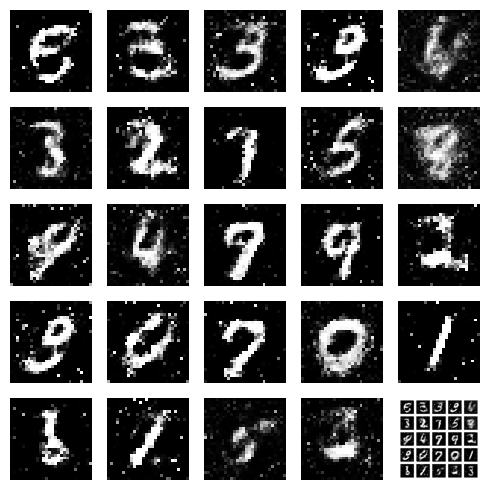

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 2/350 [00:00<00:26, 13.15it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:25, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:24, 14.32it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 8/350 [00:00<00:23, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:23, 14.22it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 12/350 [00:00<00:23, 14.28it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 14/350 [00:00<00:23, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:22, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:22, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:22, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:24, 13.01it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:23, 13.57it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:22, 13.95it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:23, 13.79it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:22, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:21, 14.36it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 38/350 [00:02<00:21, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:21, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:20, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:20, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:20, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:20, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.66it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 52/350 [00:03<00:20, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:20, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:20, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:19, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:22, 13.10it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:21, 13.55it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:20, 14.00it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 66/350 [00:04<00:19, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:19, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:19, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:05<00:19, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:19, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:19, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:18, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:18, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:17, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:06<00:17, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:17, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:17, 14.71it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 94/350 [00:06<00:20, 12.71it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 96/350 [00:06<00:19, 13.24it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:18, 13.75it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:07<00:17, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:07<00:17, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:17, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:17, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:16, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:16, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:16, 14.49it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 116/350 [00:08<00:16, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:16, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:15, 14.77it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 128/350 [00:08<00:16, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:15, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:15, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:15, 14.38it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 136/350 [00:09<00:14, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:14, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:09<00:14, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:10<00:13, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:13, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:13, 14.91it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:13, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:13, 14.99it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:12, 15.14it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:10<00:12, 15.01it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 160/350 [00:11<00:14, 13.53it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:13, 13.63it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:11<00:13, 13.94it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:12, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:12, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:11<00:12, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:12<00:12, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:12<00:11, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:11, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:11, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:11, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:11, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:10, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:13<00:10, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:13<00:10, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 15.00it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▌    | 196/350 [00:13<00:11, 13.27it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:13, 10.90it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:14<00:12, 11.86it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:14<00:11, 12.47it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:14<00:11, 13.08it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:14<00:10, 13.64it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:14<00:10, 13.99it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:14<00:09, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:09, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:15<00:09, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:15<00:09, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:15<00:09, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:15<00:09, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:15<00:08, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:08, 14.52it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▌   | 228/350 [00:16<00:09, 13.53it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 230/350 [00:16<00:08, 13.60it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:16<00:08, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:16<00:08, 14.08it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:16<00:07, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:16<00:07, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:07, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:16<00:07, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:17<00:07, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:17<00:07, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:17<00:07, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:17<00:06, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:17<00:06, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:17<00:06, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:17<00:06, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:18<00:06, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:18<00:06, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:18<00:06, 13.26it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:18<00:06, 13.76it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:18<00:06, 13.50it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:18<00:05, 13.89it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:18<00:05, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:19<00:05, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:19<00:05, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:19<00:05, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:19<00:04, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:19<00:04, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:19<00:04, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:19<00:04, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:20<00:04, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:20<00:04, 14.66it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 290/350 [00:20<00:04, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:20<00:03, 14.86it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 294/350 [00:20<00:03, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:20<00:03, 14.85it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 298/350 [00:20<00:04, 12.89it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:21<00:03, 13.46it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:21<00:03, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:21<00:03, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:21<00:03, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:21<00:02, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:21<00:02, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:21<00:02, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:22<00:02, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:22<00:02, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:22<00:02, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:22<00:02, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:22<00:01, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:22<00:01, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:22<00:01, 14.61it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▎| 328/350 [00:23<00:01, 13.43it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:23<00:01, 13.58it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:23<00:01, 13.97it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:23<00:01, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:23<00:00, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:23<00:00, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:23<00:00, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:23<00:00, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:24<00:00, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:24<00:00, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:24<00:00, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:24<00:00, 14.29it/s]

Epoch number: 22 discriminator_loss: 0.6480500894784927 generator_loss: 0.9868114229610988
1/1 [==============================] - 0s 12ms/step


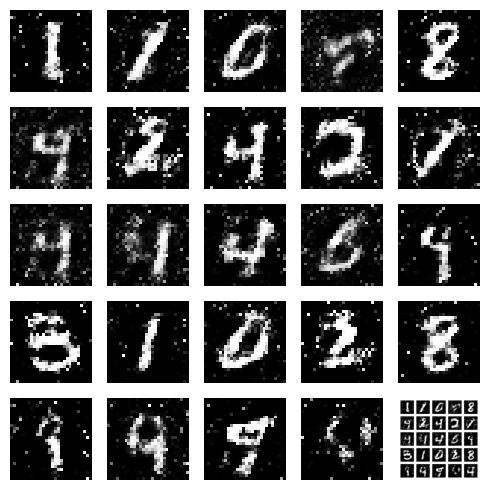

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 2/350 [00:00<00:26, 12.90it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:25, 13.40it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 6/350 [00:00<00:25, 13.53it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:24, 13.69it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 10/350 [00:00<00:26, 12.75it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:25, 13.40it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:01<00:24, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:23, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:23, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:22, 14.63it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 26/350 [00:01<00:22, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:22, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:21, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:21, 14.85it/s]

4/4 [==============================] - 0s 3ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:21, 14.90it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 38/350 [00:02<00:21, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:21, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:21, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:20, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:23, 12.93it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:22, 13.18it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:21, 13.65it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 52/350 [00:03<00:21, 13.91it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:21, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:20, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:20, 14.42it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 60/350 [00:04<00:20, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:20, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:19, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:19, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:19, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:19, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:05<00:19, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:18, 14.56it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 76/350 [00:05<00:21, 12.90it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:20, 13.37it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:19, 13.72it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:18, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:06<00:18, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:06<00:18, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:17, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:17, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:17, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:17, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:17, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:07<00:16, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:07<00:16, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:16, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:18, 13.51it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 108/350 [00:07<00:18, 13.26it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:17, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:16, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:08<00:16, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:15, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:15, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:15, 14.38it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 128/350 [00:08<00:15, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:15, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:14, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:14, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:14, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.68it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████      | 140/350 [00:09<00:16, 13.12it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:10<00:15, 13.50it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:10<00:14, 13.83it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:14, 13.97it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 148/350 [00:10<00:14, 13.98it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:14, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:13, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:13, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:13, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:11<00:13, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:11<00:12, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:12, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:11<00:12, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:12, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:12, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:12<00:12, 14.64it/s]

4/4 [==============================] - 0s 9ms/step


 50%|████▉     | 174/350 [00:12<00:13, 13.21it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:12<00:12, 13.54it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:12, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:12, 14.16it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:11, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:13<00:11, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:11, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:13<00:11, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:13<00:10, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:10, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:10, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:14<00:10, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:14<00:10, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:14<00:09, 14.68it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 206/350 [00:14<00:09, 14.50it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 208/350 [00:14<00:10, 13.90it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:14<00:10, 13.39it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:09, 13.87it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:15<00:09, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:15<00:09, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:15<00:09, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:15<00:08, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:15<00:08, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 14.84it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 226/350 [00:15<00:08, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:08, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:16<00:08, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:16<00:08, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:16<00:07, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:16<00:07, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:16<00:07, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:07, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:16<00:08, 13.24it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:17<00:07, 13.64it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 246/350 [00:17<00:07, 13.77it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:17<00:07, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:17<00:06, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:17<00:08, 11.23it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:17<00:07, 12.07it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:18<00:07, 12.77it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:18<00:06, 13.29it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:18<00:06, 13.71it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:18<00:06, 13.98it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:18<00:06, 14.06it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:18<00:06, 13.90it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:18<00:05, 14.00it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:19<00:05, 14.13it/s]

4/4 [==============================] - 0s 11ms/step


 78%|███████▊  | 272/350 [00:19<00:05, 13.24it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:19<00:05, 13.45it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:19<00:05, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:19<00:05, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:19<00:04, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:19<00:04, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:20<00:04, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:20<00:04, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:20<00:04, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:20<00:04, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:20<00:04, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:20<00:03, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:20<00:03, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:21<00:03, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:21<00:03, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:21<00:03, 14.16it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 304/350 [00:21<00:03, 13.07it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 306/350 [00:21<00:03, 13.04it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:21<00:03, 13.49it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:21<00:02, 13.85it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:22<00:02, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:22<00:02, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:22<00:02, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:22<00:02, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:22<00:02, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:22<00:01, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:22<00:01, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:23<00:01, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:23<00:01, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:23<00:01, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:23<00:01, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:23<00:01, 14.32it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 336/350 [00:23<00:01, 13.43it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 338/350 [00:23<00:00, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:24<00:00, 13.89it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:24<00:00, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:24<00:00, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:24<00:00, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:24<00:00, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:24<00:00, 14.16it/s]

Epoch number: 23 discriminator_loss: 0.6457202982051032 generator_loss: 0.9886650311946868
1/1 [==============================] - 0s 11ms/step


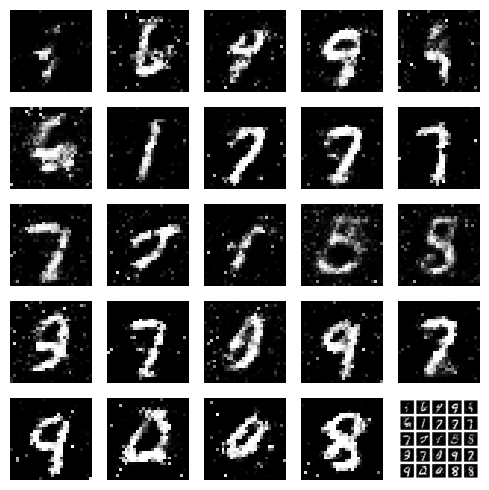

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:25, 13.59it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:25, 13.80it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:24, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:24, 14.24it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 10/350 [00:00<00:24, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:24, 13.87it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:00<00:23, 14.12it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 16/350 [00:01<00:26, 12.59it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:25, 13.17it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:24, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:23, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:23, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:22, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:02<00:22, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:22, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:22, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:21, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:21, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:21, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:21, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:20, 14.69it/s]

4/4 [==============================] - 0s 11ms/step


 13%|█▎        | 46/350 [00:03<00:22, 13.43it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:22, 13.38it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:21, 13.78it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:21, 14.06it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:20, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:20, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:19, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:19, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:19, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:19, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:19, 14.89it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 68/350 [00:04<00:19, 14.49it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 70/350 [00:04<00:19, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:05<00:19, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:18, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:18, 14.66it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 78/350 [00:05<00:20, 13.26it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:20, 13.47it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:19, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.24it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▍       | 86/350 [00:06<00:18, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:06<00:18, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:18, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:17, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:17, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:17, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:17, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:07<00:17, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:07<00:16, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:16, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:16, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:16, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:18, 13.29it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:17, 13.56it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:08<00:17, 13.84it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:16, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:16, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:19, 11.57it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:09<00:17, 12.37it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:16, 13.13it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:16, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:15, 13.79it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:15, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:14, 14.58it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 142/350 [00:10<00:15, 13.33it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:10<00:15, 13.19it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:15, 13.55it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:14, 13.84it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:14, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:13, 14.39it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 154/350 [00:10<00:13, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:11<00:13, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:11<00:13, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:11<00:12, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:13, 14.44it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 164/350 [00:11<00:13, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:12, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:12<00:12, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:12<00:12, 14.53it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████▉     | 174/350 [00:12<00:13, 13.24it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 176/350 [00:12<00:12, 13.49it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:12, 13.90it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:12, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:12, 13.81it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:13<00:11, 14.10it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:13<00:11, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:11, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:13<00:10, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:13<00:10, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:10, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:14<00:10, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:14<00:10, 14.33it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 202/350 [00:14<00:10, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:14<00:10, 14.37it/s]

4/4 [==============================] - 0s 10ms/step


 59%|█████▉    | 206/350 [00:14<00:10, 13.31it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 208/350 [00:14<00:10, 13.62it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:14<00:10, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:15<00:09, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:15<00:09, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:15<00:09, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:15<00:09, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:15<00:09, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:15<00:09, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:08, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:16<00:08, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:16<00:08, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:16<00:08, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:16<00:08, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:16<00:07, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:16<00:08, 13.12it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:17<00:08, 13.55it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:17<00:07, 13.83it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:17<00:07, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:17<00:07, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:17<00:07, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:17<00:06, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:17<00:06, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:17<00:06, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:18<00:06, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:18<00:06, 14.12it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 260/350 [00:18<00:06, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:18<00:06, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:18<00:06, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:18<00:05, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:18<00:05, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:19<00:05, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:19<00:05, 13.02it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:19<00:05, 13.37it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:19<00:05, 13.50it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:19<00:05, 13.48it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 280/350 [00:19<00:05, 13.70it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:19<00:04, 13.95it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:20<00:04, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:20<00:04, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:20<00:04, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:20<00:04, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:20<00:04, 14.29it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:20<00:03, 14.33it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▍ | 296/350 [00:20<00:03, 13.98it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:21<00:03, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:21<00:03, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▋ | 302/350 [00:21<00:03, 12.76it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:21<00:03, 13.19it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:21<00:03, 13.67it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:21<00:02, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:21<00:02, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:22<00:02, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:22<00:02, 14.40it/s]

4/4 [==============================] - 0s 3ms/step


 90%|█████████ | 316/350 [00:22<00:02, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:22<00:02, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:22<00:02, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:22<00:01, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:22<00:01, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:23<00:01, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:23<00:01, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:23<00:01, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:23<00:01, 12.92it/s]

4/4 [==============================] - 0s 1ms/step


 95%|█████████▌| 334/350 [00:23<00:01, 13.41it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:23<00:01, 13.36it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:23<00:00, 13.75it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 340/350 [00:24<00:00, 13.96it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:24<00:00, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:24<00:00, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:24<00:00, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:24<00:00, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:24<00:00, 14.11it/s]

Epoch number: 24 discriminator_loss: 0.6470105813230786 generator_loss: 0.9838563062463488
1/1 [==============================] - 0s 11ms/step


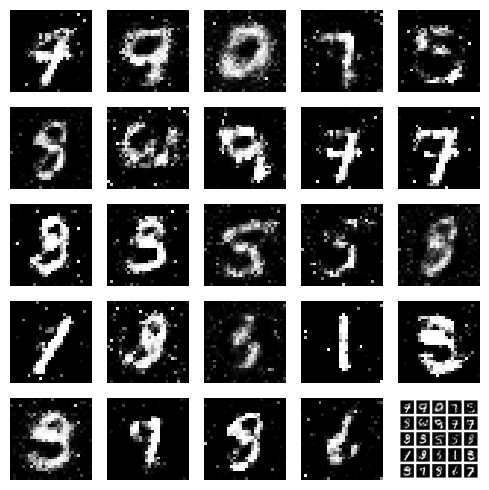

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 2/350 [00:00<00:33, 10.39it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:27, 12.53it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:25, 13.41it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 8/350 [00:00<00:28, 11.79it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:27, 12.42it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:25, 13.08it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:01<00:24, 13.59it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:24, 13.83it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:23, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:23, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:23, 13.67it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 24/350 [00:01<00:23, 13.85it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:22, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:02<00:22, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:22, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:21, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:21, 14.70it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 38/350 [00:02<00:23, 13.23it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█▏        | 40/350 [00:02<00:23, 13.02it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 42/350 [00:03<00:22, 13.50it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:22, 13.72it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:21, 13.98it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:21, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:20, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:20, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:04<00:19, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:20, 14.48it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:19, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:19, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:19, 14.80it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 66/350 [00:04<00:19, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:19, 14.67it/s]

4/4 [==============================] - 0s 7ms/step


 20%|██        | 70/350 [00:05<00:20, 13.60it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 72/350 [00:05<00:20, 13.49it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:19, 13.99it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:19, 13.96it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 78/350 [00:05<00:18, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:18, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:18, 14.76it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 84/350 [00:05<00:17, 14.78it/s]

4/4 [==============================] - 0s 1ms/step


 25%|██▍       | 86/350 [00:06<00:17, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 88/350 [00:06<00:17, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:17, 14.77it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▋       | 92/350 [00:06<00:17, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:17, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:17, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:17, 14.77it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▊       | 100/350 [00:07<00:16, 14.71it/s]

4/4 [==============================] - 0s 11ms/step


 29%|██▉       | 102/350 [00:07<00:18, 13.51it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:17, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:17, 14.01it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:17, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:17, 13.98it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:08<00:16, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:16, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:15, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:15, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:09<00:15, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:15, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:15, 14.41it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 134/350 [00:09<00:16, 12.94it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:15, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:15, 13.96it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:14, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:10<00:14, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:10<00:14, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:14, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:14, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:13, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:13, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:13, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:13, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:11<00:13, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:11<00:12, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:12, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:11<00:14, 13.12it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:13, 13.57it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:12, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:12<00:12, 14.46it/s]

4/4 [==============================] - 0s 3ms/step


 50%|████▉     | 174/350 [00:12<00:12, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:12<00:11, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:11, 14.70it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████▏    | 180/350 [00:12<00:11, 14.67it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:12<00:11, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:13<00:11, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:11, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:13<00:10, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:13<00:10, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:11, 13.02it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:11, 13.45it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:10, 13.84it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:14<00:10, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:14<00:10, 14.34it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 204/350 [00:14<00:10, 13.79it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:14<00:10, 14.01it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:14<00:10, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:14<00:09, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:14<00:09, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:15<00:09, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:15<00:09, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:15<00:08, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:15<00:08, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:15<00:08, 14.40it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 224/350 [00:15<00:09, 12.70it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:15<00:09, 13.33it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:16<00:08, 13.87it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:16<00:08, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:16<00:08, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:16<00:07, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:16<00:07, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:16<00:07, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:07, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:17<00:07, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:17<00:07, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:17<00:07, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:17<00:06, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:17<00:06, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:17<00:06, 14.79it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 254/350 [00:17<00:07, 13.15it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:18<00:06, 13.49it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:18<00:06, 13.62it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:18<00:06, 14.07it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:18<00:06, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:18<00:06, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:18<00:05, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:18<00:05, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:18<00:05, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:19<00:05, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:19<00:05, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:19<00:05, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:19<00:04, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:19<00:04, 14.66it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████  | 282/350 [00:19<00:04, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:19<00:04, 14.66it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 286/350 [00:20<00:04, 13.12it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:20<00:04, 13.63it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 290/350 [00:20<00:04, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:20<00:04, 14.24it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 294/350 [00:20<00:03, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:20<00:03, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:20<00:03, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:21<00:03, 14.70it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▋ | 302/350 [00:21<00:03, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:21<00:03, 14.67it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 306/350 [00:21<00:03, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:21<00:02, 14.64it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▊ | 310/350 [00:21<00:02, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:21<00:02, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:22<00:02, 14.45it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 316/350 [00:22<00:02, 13.23it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:22<00:02, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:22<00:02, 14.08it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:22<00:01, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:22<00:01, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:22<00:01, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:23<00:01, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:23<00:01, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:23<00:01, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:23<00:01, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:23<00:00, 14.41it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 338/350 [00:23<00:00, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:23<00:00, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:23<00:00, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:24<00:00, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:24<00:00, 12.95it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:24<00:00, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:24<00:00, 14.24it/s]

Epoch number: 25 discriminator_loss: 0.6521576523780823 generator_loss: 0.971461877993175
1/1 [==============================] - 0s 10ms/step


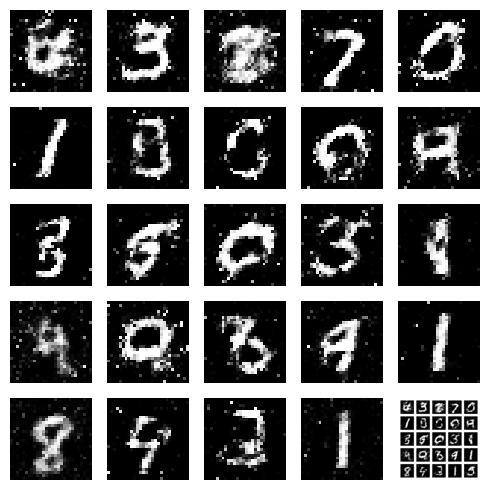

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 2/350 [00:00<00:28, 12.10it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:26, 12.98it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:25, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:24, 13.76it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:24, 13.80it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:24, 13.86it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:01<00:24, 13.83it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 16/350 [00:01<00:24, 13.68it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:24, 13.58it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:23, 13.76it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 22/350 [00:01<00:26, 12.61it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:24, 13.05it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:24, 13.47it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:02<00:23, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:22, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:22, 14.03it/s]

4/4 [==============================] - 0s 3ms/step


 10%|▉         | 34/350 [00:02<00:22, 13.95it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:22, 14.07it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:21, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:21, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:03<00:21, 14.28it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 44/350 [00:03<00:21, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:21, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:21, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.40it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 52/350 [00:03<00:21, 14.00it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▌        | 54/350 [00:03<00:23, 12.50it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 56/350 [00:04<00:22, 13.18it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 58/350 [00:04<00:21, 13.51it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:21, 13.72it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:20, 14.00it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 64/350 [00:04<00:20, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:19, 14.46it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:19, 14.61it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 70/350 [00:05<00:19, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:05<00:19, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 74/350 [00:05<00:19, 14.45it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 76/350 [00:05<00:18, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:18, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:18, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:06<00:20, 12.71it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:06<00:19, 13.27it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 88/350 [00:06<00:19, 13.40it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:18, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:18, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:17, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:17, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:07<00:17, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:07<00:17, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:07<00:17, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:17, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:16, 14.49it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 108/350 [00:07<00:17, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:17, 14.07it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:08<00:16, 14.33it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 114/350 [00:08<00:18, 12.49it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:17, 13.09it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:17, 13.43it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:16, 13.80it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:16, 13.80it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:16, 14.01it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 126/350 [00:09<00:16, 13.63it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:09<00:15, 14.03it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:15, 14.21it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 132/350 [00:09<00:15, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:15, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:14, 14.35it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.47it/s]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 140/350 [00:10<00:14, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:10<00:14, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:10<00:16, 12.50it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 146/350 [00:10<00:15, 12.97it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:14, 13.51it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 150/350 [00:10<00:14, 13.88it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:14, 13.96it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:11<00:14, 13.96it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 156/350 [00:11<00:13, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:11<00:13, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:11<00:13, 14.31it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▋     | 162/350 [00:11<00:13, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:11<00:13, 14.03it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:13, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:12<00:12, 14.03it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:12<00:12, 14.06it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▉     | 172/350 [00:12<00:13, 12.73it/s]

4/4 [==============================] - 0s 2ms/step


 50%|████▉     | 174/350 [00:12<00:13, 13.25it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 176/350 [00:12<00:12, 13.48it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 178/350 [00:12<00:12, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:12, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:13<00:12, 13.86it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:13<00:11, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:13<00:11, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:11, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:13<00:11, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 192/350 [00:13<00:11, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:14<00:10, 14.34it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 198/350 [00:14<00:10, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:14<00:10, 14.04it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 202/350 [00:14<00:11, 12.57it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 204/350 [00:14<00:11, 13.15it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:14<00:10, 13.38it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:14<00:10, 13.60it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 210/350 [00:15<00:10, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:15<00:09, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:15<00:09, 14.15it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 216/350 [00:15<00:09, 13.82it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 218/350 [00:15<00:09, 13.78it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:15<00:09, 13.93it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 222/350 [00:15<00:09, 14.01it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:16<00:08, 14.11it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 226/350 [00:16<00:08, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:16<00:08, 13.76it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 230/350 [00:16<00:09, 12.39it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 232/350 [00:16<00:09, 12.57it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 234/350 [00:16<00:09, 12.51it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:17<00:09, 12.64it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 238/350 [00:17<00:08, 13.03it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▊   | 240/350 [00:17<00:08, 13.26it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:17<00:07, 13.50it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:17<00:07, 13.72it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 246/350 [00:17<00:07, 13.78it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:17<00:07, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:18<00:07, 14.06it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 252/350 [00:18<00:07, 13.91it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:18<00:06, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:18<00:06, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:18<00:06, 14.39it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 260/350 [00:18<00:07, 12.81it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:18<00:06, 13.30it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 264/350 [00:19<00:06, 13.66it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:19<00:06, 13.63it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 268/350 [00:19<00:06, 11.91it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 270/350 [00:19<00:06, 11.73it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 272/350 [00:19<00:06, 11.83it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:19<00:06, 12.30it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:20<00:05, 12.76it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:20<00:05, 13.25it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 280/350 [00:20<00:05, 13.38it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 282/350 [00:20<00:05, 13.54it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:20<00:04, 13.74it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 286/350 [00:20<00:05, 12.57it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 288/350 [00:21<00:04, 12.64it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 290/350 [00:21<00:04, 12.55it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 292/350 [00:21<00:05, 11.12it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 294/350 [00:21<00:04, 11.88it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:21<00:04, 12.36it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:21<00:04, 12.92it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:21<00:03, 13.47it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▋ | 302/350 [00:22<00:03, 13.70it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 304/350 [00:22<00:03, 13.60it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 306/350 [00:22<00:03, 13.39it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 308/350 [00:22<00:03, 13.45it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▊ | 310/350 [00:22<00:02, 13.34it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 312/350 [00:22<00:02, 13.50it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:23<00:02, 13.60it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:23<00:02, 12.15it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:23<00:02, 12.79it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:23<00:02, 13.20it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:23<00:02, 13.54it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 324/350 [00:23<00:01, 13.42it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:23<00:01, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:24<00:01, 14.09it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 330/350 [00:24<00:01, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:24<00:01, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:24<00:01, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:24<00:00, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:24<00:00, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:24<00:00, 14.34it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 342/350 [00:25<00:00, 12.19it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 344/350 [00:25<00:00, 12.73it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:25<00:00, 13.33it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:25<00:00, 13.71it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 350/350 [00:25<00:00, 13.64it/s]

Epoch number: 26 discriminator_loss: 0.6500584889309747 generator_loss: 0.9683489695617131
1/1 [==============================] - 0s 11ms/step


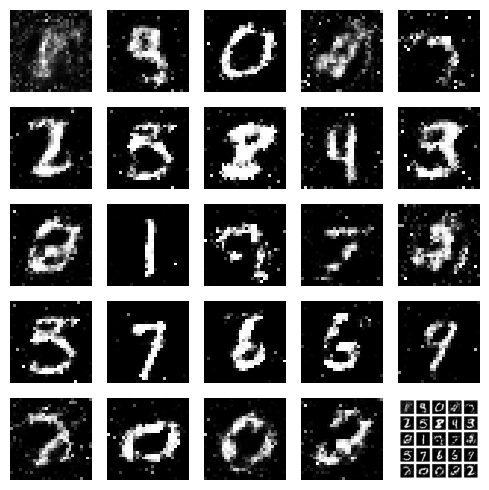

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:27, 12.69it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:25, 13.31it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 6/350 [00:00<00:25, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:25, 13.62it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 10/350 [00:00<00:24, 13.81it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:24, 13.91it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:01<00:23, 14.11it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 16/350 [00:01<00:26, 12.38it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:25, 13.09it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:24, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:23, 14.06it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 24/350 [00:01<00:23, 13.87it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 26/350 [00:01<00:23, 14.03it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:02<00:22, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:22, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:22, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:21, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:21, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:21, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:03<00:21, 14.40it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 44/350 [00:03<00:22, 13.46it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:22, 13.67it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:21, 13.92it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:21, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:20, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:20, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:04<00:20, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:19, 14.75it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 60/350 [00:04<00:20, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:20, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:19, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:19, 14.39it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 68/350 [00:04<00:19, 14.38it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 70/350 [00:04<00:19, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:05<00:19, 14.51it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 74/350 [00:05<00:21, 12.83it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:20, 13.43it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:19, 13.62it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:19, 13.79it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:18, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:06<00:24, 10.80it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 88/350 [00:06<00:22, 11.66it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:21, 12.29it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:20, 12.57it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 94/350 [00:06<00:19, 13.13it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:19, 13.33it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:07<00:18, 13.72it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▊       | 100/350 [00:07<00:17, 13.92it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██▉       | 102/350 [00:07<00:19, 12.68it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:19, 12.89it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:18, 13.18it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:17, 13.52it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 110/350 [00:08<00:17, 13.66it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 112/350 [00:08<00:17, 13.89it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:08<00:17, 13.71it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:16, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:16, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:09<00:15, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:09<00:15, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:15, 14.61it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 132/350 [00:09<00:16, 13.51it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:16, 13.41it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:15, 13.73it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:10<00:15, 14.09it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:10<00:14, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:10<00:14, 14.47it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 144/350 [00:10<00:14, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:14, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:13, 14.44it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 150/350 [00:10<00:14, 13.95it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:13, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:11<00:13, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:11<00:13, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:11<00:13, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:11<00:12, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:12, 14.78it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 164/350 [00:11<00:13, 13.67it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:13, 13.67it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 168/350 [00:12<00:13, 13.63it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:12<00:13, 13.81it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:12<00:12, 14.11it/s]

4/4 [==============================] - 0s 3ms/step


 50%|████▉     | 174/350 [00:12<00:12, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:12<00:12, 14.37it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 178/350 [00:12<00:12, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:11, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:13<00:11, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:13<00:11, 14.63it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 186/350 [00:13<00:11, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:11, 14.17it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 190/350 [00:13<00:11, 14.29it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 192/350 [00:13<00:12, 13.04it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:11, 13.28it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:14<00:11, 13.68it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 198/350 [00:14<00:10, 13.90it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:14<00:10, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:14<00:10, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:14<00:10, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:14<00:10, 13.79it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:14<00:10, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:15<00:09, 14.24it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 212/350 [00:15<00:09, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:15<00:09, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:15<00:09, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:15<00:09, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 220/350 [00:15<00:09, 14.41it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 222/350 [00:15<00:09, 13.12it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 224/350 [00:16<00:09, 13.09it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 226/350 [00:16<00:09, 13.47it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:16<00:08, 13.86it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:16<00:08, 14.10it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 232/350 [00:16<00:08, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:16<00:08, 14.50it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 236/350 [00:16<00:08, 14.05it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 238/350 [00:17<00:08, 13.96it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▊   | 240/350 [00:17<00:07, 13.94it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:17<00:07, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:17<00:07, 14.32it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:17<00:07, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:17<00:06, 14.61it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████▏  | 250/350 [00:17<00:06, 14.51it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 252/350 [00:18<00:07, 13.65it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 254/350 [00:18<00:07, 13.67it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:18<00:06, 13.88it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▎  | 258/350 [00:18<00:06, 13.94it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:18<00:06, 14.11it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:18<00:06, 14.34it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 264/350 [00:18<00:06, 14.32it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 266/350 [00:19<00:05, 14.10it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:19<00:05, 14.23it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 270/350 [00:19<00:05, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:19<00:05, 14.22it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 274/350 [00:19<00:05, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:19<00:05, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:19<00:04, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:20<00:04, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:20<00:04, 14.86it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████  | 284/350 [00:20<00:04, 13.24it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:20<00:04, 13.71it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:20<00:04, 13.88it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 290/350 [00:20<00:04, 13.70it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 292/350 [00:20<00:04, 14.00it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:21<00:03, 14.30it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▍ | 296/350 [00:21<00:03, 14.28it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:21<00:03, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 300/350 [00:21<00:03, 14.65it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▋ | 302/350 [00:21<00:03, 14.67it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 304/350 [00:21<00:03, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:21<00:02, 14.72it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:22<00:02, 14.56it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▊ | 310/350 [00:22<00:02, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:22<00:02, 14.81it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:22<00:02, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:22<00:02, 13.87it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 318/350 [00:22<00:02, 13.96it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:22<00:02, 14.38it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:22<00:01, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:23<00:01, 14.63it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 326/350 [00:23<00:01, 14.53it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▎| 328/350 [00:23<00:01, 14.18it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 330/350 [00:23<00:01, 14.16it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 332/350 [00:23<00:01, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 334/350 [00:23<00:01, 14.40it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:23<00:00, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:24<00:00, 14.35it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 340/350 [00:24<00:00, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:24<00:00, 14.43it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 344/350 [00:24<00:00, 14.00it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 346/350 [00:24<00:00, 14.20it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 348/350 [00:24<00:00, 13.67it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 350/350 [00:24<00:00, 14.02it/s]

Epoch number: 27 discriminator_loss: 0.6490787031820843 generator_loss: 0.9807491820199149
1/1 [==============================] - 0s 11ms/step


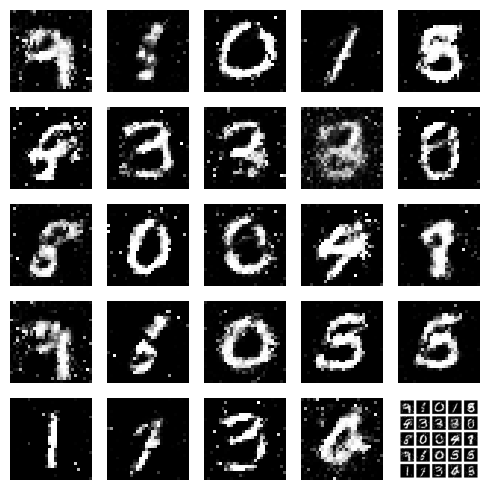

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:29, 11.77it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:27, 12.72it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 6/350 [00:00<00:26, 13.16it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 8/350 [00:00<00:25, 13.63it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 10/350 [00:00<00:25, 13.23it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:24, 13.88it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 14/350 [00:01<00:23, 14.06it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 16/350 [00:01<00:23, 14.15it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:23, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.73it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:22, 14.50it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 26/350 [00:01<00:25, 12.93it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:02<00:24, 13.28it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:23, 13.59it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 32/350 [00:02<00:22, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:21, 14.62it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 36/350 [00:02<00:21, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:20, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:20, 15.05it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:20, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 44/350 [00:03<00:20, 15.15it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 46/350 [00:03<00:20, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:20, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:19, 15.17it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 52/350 [00:03<00:20, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:20, 14.79it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:19, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 58/350 [00:04<00:19, 14.88it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 60/350 [00:04<00:22, 12.92it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:21, 13.43it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:20, 13.79it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 66/350 [00:04<00:21, 13.24it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 68/350 [00:04<00:20, 13.68it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 70/350 [00:04<00:20, 13.91it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 72/350 [00:05<00:19, 14.19it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 74/350 [00:05<00:19, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 76/350 [00:05<00:18, 14.56it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:18, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:18, 14.92it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 82/350 [00:05<00:18, 14.78it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.26it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:06<00:18, 14.18it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 88/350 [00:06<00:19, 13.56it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 90/350 [00:06<00:18, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▋       | 92/350 [00:06<00:18, 14.11it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 94/350 [00:06<00:18, 14.07it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 96/350 [00:06<00:17, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:17, 14.38it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▊       | 100/350 [00:07<00:17, 14.51it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 102/350 [00:07<00:17, 13.93it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:17, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:17, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:16, 14.46it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:16, 14.77it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:15, 15.02it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▎      | 118/350 [00:08<00:17, 13.56it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:16, 13.66it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 122/350 [00:08<00:15, 14.25it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:15, 14.49it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:15, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:14, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:14, 14.75it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:14, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:14, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 138/350 [00:09<00:14, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:18, 11.34it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 142/350 [00:10<00:16, 12.32it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 144/350 [00:10<00:16, 12.82it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:15, 13.17it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:14, 13.63it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:15, 12.66it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:14, 13.26it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:14, 13.71it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 156/350 [00:11<00:14, 13.79it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 158/350 [00:11<00:13, 14.23it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 160/350 [00:11<00:13, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:12, 14.69it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 164/350 [00:11<00:12, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:12, 14.47it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 168/350 [00:11<00:12, 14.42it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▊     | 170/350 [00:12<00:12, 14.36it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 172/350 [00:12<00:12, 14.45it/s]

4/4 [==============================] - 0s 3ms/step


 50%|████▉     | 174/350 [00:12<00:12, 14.26it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 176/350 [00:12<00:11, 14.53it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 178/350 [00:12<00:11, 14.51it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:12, 13.32it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 182/350 [00:12<00:12, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 184/350 [00:13<00:11, 13.99it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:13<00:11, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:11, 14.33it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 190/350 [00:13<00:10, 14.56it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 192/350 [00:13<00:11, 14.14it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:10, 14.71it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:10, 15.00it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 200/350 [00:14<00:09, 15.23it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 202/350 [00:14<00:09, 15.17it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 204/350 [00:14<00:09, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:14<00:09, 15.41it/s]

4/4 [==============================] - 0s 1ms/step


 59%|█████▉    | 208/350 [00:14<00:09, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:14<00:09, 15.22it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 212/350 [00:14<00:10, 12.84it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:15<00:10, 13.45it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:15<00:09, 14.03it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 218/350 [00:15<00:09, 14.15it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 220/350 [00:15<00:09, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:15<00:08, 14.50it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 14.55it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 226/350 [00:15<00:08, 14.55it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▌   | 228/350 [00:16<00:08, 14.61it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 230/350 [00:16<00:08, 14.28it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 232/350 [00:16<00:08, 14.25it/s]

4/4 [==============================] - 0s 1ms/step


 67%|██████▋   | 234/350 [00:16<00:07, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 236/350 [00:16<00:07, 14.79it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 238/350 [00:16<00:07, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:07, 14.68it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 242/350 [00:17<00:08, 12.95it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:17<00:07, 13.70it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:17<00:07, 14.12it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 248/350 [00:17<00:07, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:17<00:06, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 252/350 [00:17<00:06, 14.62it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 254/350 [00:17<00:06, 14.58it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 256/350 [00:18<00:06, 14.63it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▎  | 258/350 [00:18<00:06, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:18<00:06, 14.83it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:18<00:05, 14.95it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:18<00:05, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:18<00:05, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:18<00:05, 14.70it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 270/350 [00:18<00:05, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:19<00:05, 13.75it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:19<00:05, 13.75it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:19<00:05, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 278/350 [00:19<00:05, 14.27it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 280/350 [00:19<00:04, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:19<00:04, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:19<00:04, 14.53it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 286/350 [00:20<00:04, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:20<00:04, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:20<00:04, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:20<00:04, 14.49it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 294/350 [00:20<00:03, 14.40it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▍ | 296/350 [00:20<00:03, 14.43it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:20<00:03, 14.45it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 300/350 [00:21<00:03, 13.96it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▋ | 302/350 [00:21<00:03, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:21<00:03, 13.47it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:21<00:03, 13.75it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 308/350 [00:21<00:02, 14.05it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:21<00:02, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:21<00:02, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:22<00:02, 14.39it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 316/350 [00:22<00:02, 14.02it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 318/350 [00:22<00:02, 14.22it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:22<00:02, 14.37it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:22<00:01, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:22<00:01, 14.19it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 326/350 [00:22<00:01, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:23<00:01, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:23<00:01, 14.78it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 332/350 [00:23<00:01, 14.83it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 334/350 [00:23<00:01, 12.16it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 336/350 [00:23<00:01, 13.01it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 338/350 [00:23<00:00, 13.53it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 340/350 [00:23<00:00, 13.87it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 342/350 [00:24<00:00, 14.08it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 344/350 [00:24<00:00, 14.02it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:24<00:00, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:24<00:00, 14.36it/s]

4/4 [==============================] - 0s 1ms/step


100%|██████████| 350/350 [00:24<00:00, 14.22it/s]

Epoch number: 28 discriminator_loss: 0.652974984901292 generator_loss: 0.9746270171233586
1/1 [==============================] - 0s 11ms/step


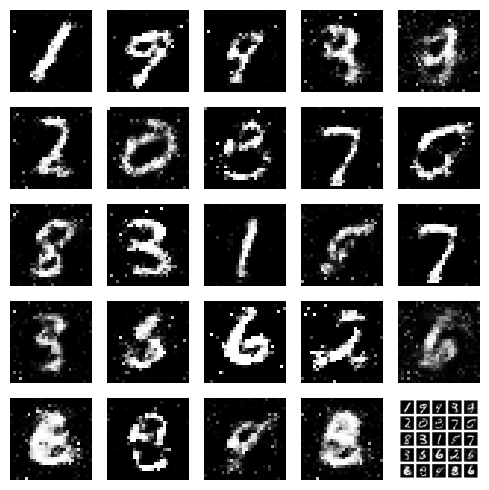

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 2/350 [00:00<00:24, 14.06it/s]

4/4 [==============================] - 0s 2ms/step


  1%|          | 4/350 [00:00<00:24, 14.02it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 6/350 [00:00<00:23, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 8/350 [00:00<00:23, 14.46it/s]

4/4 [==============================] - 0s 8ms/step


  3%|▎         | 10/350 [00:00<00:25, 13.21it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 12/350 [00:00<00:25, 13.43it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 14/350 [00:01<00:23, 14.10it/s]

4/4 [==============================] - 0s 1ms/step


  5%|▍         | 16/350 [00:01<00:23, 14.45it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 18/350 [00:01<00:23, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▌         | 20/350 [00:01<00:22, 14.66it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 22/350 [00:01<00:22, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 24/350 [00:01<00:21, 15.02it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 26/350 [00:01<00:21, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 28/350 [00:01<00:21, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 30/350 [00:02<00:21, 15.05it/s]

4/4 [==============================] - 0s 1ms/step


  9%|▉         | 32/350 [00:02<00:20, 15.23it/s]

4/4 [==============================] - 0s 2ms/step


 10%|▉         | 34/350 [00:02<00:20, 15.53it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 36/350 [00:02<00:20, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 38/350 [00:02<00:21, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█▏        | 40/350 [00:02<00:20, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 42/350 [00:02<00:20, 14.96it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 44/350 [00:03<00:22, 13.78it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 46/350 [00:03<00:22, 13.67it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▎        | 48/350 [00:03<00:21, 14.10it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 50/350 [00:03<00:20, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 52/350 [00:03<00:20, 14.30it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▌        | 54/350 [00:03<00:20, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 56/350 [00:03<00:20, 14.58it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 58/350 [00:03<00:20, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 60/350 [00:04<00:19, 14.52it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 62/350 [00:04<00:19, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 64/350 [00:04<00:19, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 66/350 [00:04<00:19, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 68/350 [00:04<00:19, 14.42it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 70/350 [00:04<00:19, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 72/350 [00:04<00:19, 14.35it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 74/350 [00:05<00:18, 14.59it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 76/350 [00:05<00:21, 12.84it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 78/350 [00:05<00:20, 13.27it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 80/350 [00:05<00:19, 13.61it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 82/350 [00:05<00:19, 13.76it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 84/350 [00:05<00:18, 14.01it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▍       | 86/350 [00:05<00:18, 14.15it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 88/350 [00:06<00:18, 13.98it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 90/350 [00:06<00:18, 14.38it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▋       | 92/350 [00:06<00:17, 14.51it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 94/350 [00:06<00:17, 14.57it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 96/350 [00:06<00:17, 14.68it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 98/350 [00:06<00:17, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▊       | 100/350 [00:06<00:16, 14.80it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 102/350 [00:07<00:16, 14.64it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 104/350 [00:07<00:18, 13.52it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 106/350 [00:07<00:18, 13.37it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███       | 108/350 [00:07<00:17, 13.82it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 110/350 [00:07<00:16, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 112/350 [00:07<00:16, 14.82it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 114/350 [00:07<00:15, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 116/350 [00:08<00:15, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 118/350 [00:08<00:15, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 120/350 [00:08<00:15, 14.59it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▍      | 122/350 [00:08<00:16, 14.17it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 124/350 [00:08<00:15, 14.54it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 126/350 [00:08<00:15, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 128/350 [00:08<00:14, 14.97it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 130/350 [00:09<00:14, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 132/350 [00:09<00:14, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 134/350 [00:09<00:14, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 136/350 [00:09<00:14, 15.00it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 138/350 [00:09<00:15, 13.50it/s]

4/4 [==============================] - 0s 2ms/step


 40%|████      | 140/350 [00:09<00:14, 14.17it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 142/350 [00:09<00:14, 14.05it/s]

4/4 [==============================] - 0s 1ms/step


 41%|████      | 144/350 [00:09<00:14, 14.65it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 146/350 [00:10<00:13, 14.96it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 148/350 [00:10<00:13, 15.08it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 150/350 [00:10<00:13, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 152/350 [00:10<00:13, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 154/350 [00:10<00:13, 15.01it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 156/350 [00:10<00:12, 15.07it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 158/350 [00:10<00:12, 15.03it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 160/350 [00:11<00:12, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▋     | 162/350 [00:11<00:12, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 164/350 [00:11<00:12, 14.74it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 166/350 [00:11<00:12, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 168/350 [00:11<00:14, 12.78it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▊     | 170/350 [00:11<00:13, 13.51it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 172/350 [00:11<00:13, 13.68it/s]

4/4 [==============================] - 0s 3ms/step


 50%|████▉     | 174/350 [00:12<00:12, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 176/350 [00:12<00:12, 14.03it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 178/350 [00:12<00:12, 13.86it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████▏    | 180/350 [00:12<00:11, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 182/350 [00:12<00:11, 14.71it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 184/350 [00:12<00:11, 14.85it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 186/350 [00:12<00:11, 14.87it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▎    | 188/350 [00:13<00:10, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 190/350 [00:13<00:10, 15.03it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 192/350 [00:13<00:10, 14.86it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 194/350 [00:13<00:10, 14.76it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▌    | 196/350 [00:13<00:12, 12.24it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 198/350 [00:13<00:11, 12.84it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 200/350 [00:13<00:11, 13.33it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 202/350 [00:14<00:10, 13.62it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 204/350 [00:14<00:10, 13.83it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 206/350 [00:14<00:10, 14.18it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 208/350 [00:14<00:09, 14.27it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 210/350 [00:14<00:09, 14.41it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 212/350 [00:14<00:10, 13.44it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 214/350 [00:14<00:09, 13.90it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 216/350 [00:15<00:09, 14.31it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 218/350 [00:15<00:09, 14.62it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 220/350 [00:15<00:08, 14.58it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 222/350 [00:15<00:08, 14.66it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 224/350 [00:15<00:08, 14.75it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 226/350 [00:15<00:09, 13.00it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▌   | 228/350 [00:15<00:08, 13.62it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 230/350 [00:16<00:08, 13.94it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 232/350 [00:16<00:08, 14.10it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 234/350 [00:16<00:08, 14.28it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 236/350 [00:16<00:07, 14.50it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 238/350 [00:16<00:07, 14.59it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▊   | 240/350 [00:16<00:07, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 242/350 [00:16<00:07, 14.89it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 244/350 [00:16<00:07, 15.11it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 246/350 [00:17<00:08, 11.74it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 248/350 [00:17<00:08, 12.13it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████▏  | 250/350 [00:17<00:07, 12.85it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 252/350 [00:17<00:07, 13.20it/s]

4/4 [==============================] - 0s 12ms/step


 73%|███████▎  | 254/350 [00:17<00:08, 11.86it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 256/350 [00:18<00:07, 12.14it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▎  | 258/350 [00:18<00:07, 12.75it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 260/350 [00:18<00:06, 13.08it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▍  | 262/350 [00:18<00:06, 13.49it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 264/350 [00:18<00:06, 13.39it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 266/350 [00:18<00:06, 13.61it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 268/350 [00:18<00:05, 13.97it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 270/350 [00:19<00:05, 13.91it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 272/350 [00:19<00:05, 14.08it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 274/350 [00:19<00:05, 14.16it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 276/350 [00:19<00:05, 14.32it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 278/350 [00:19<00:05, 14.35it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 280/350 [00:19<00:04, 14.21it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 282/350 [00:19<00:04, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████  | 284/350 [00:20<00:04, 14.34it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 286/350 [00:20<00:04, 13.36it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 288/350 [00:20<00:04, 13.70it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 290/350 [00:20<00:04, 13.89it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 292/350 [00:20<00:04, 14.04it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 294/350 [00:20<00:03, 14.13it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▍ | 296/350 [00:20<00:03, 14.34it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 298/350 [00:21<00:03, 14.46it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 300/350 [00:21<00:03, 13.97it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▋ | 302/350 [00:21<00:03, 14.39it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 304/350 [00:21<00:03, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 306/350 [00:21<00:02, 14.85it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 308/350 [00:21<00:02, 14.55it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▊ | 310/350 [00:21<00:02, 14.70it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 312/350 [00:21<00:02, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 314/350 [00:22<00:02, 12.69it/s]

4/4 [==============================] - 0s 2ms/step


 90%|█████████ | 316/350 [00:22<00:02, 13.41it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 318/350 [00:22<00:02, 13.53it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 320/350 [00:22<00:02, 14.20it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 322/350 [00:22<00:01, 14.50it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 324/350 [00:22<00:01, 14.71it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 326/350 [00:22<00:01, 14.69it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▎| 328/350 [00:23<00:01, 14.61it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 330/350 [00:23<00:01, 14.88it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 332/350 [00:23<00:01, 15.15it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 334/350 [00:23<00:01, 15.26it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 336/350 [00:23<00:00, 14.88it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 338/350 [00:23<00:00, 14.33it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 340/350 [00:23<00:00, 14.68it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 342/350 [00:24<00:00, 14.54it/s]

4/4 [==============================] - 0s 12ms/step


 98%|█████████▊| 344/350 [00:24<00:00, 13.16it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 346/350 [00:24<00:00, 13.70it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 348/350 [00:24<00:00, 14.23it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 350/350 [00:24<00:00, 14.21it/s]

Epoch number: 29 discriminator_loss: 0.6545694126401629 generator_loss: 0.9609188406808036
1/1 [==============================] - 0s 12ms/step


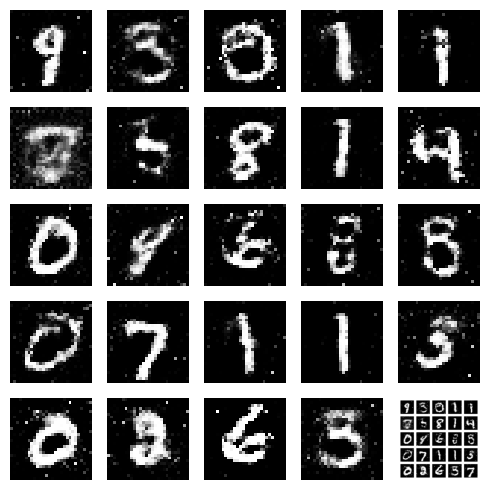

In [17]:
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

# Since we do NOT use fit
# sadly, we have to do this ourselves manually
history = {"discriminator":[],"generator":[]}

# Main training loop
for epoch_num in range(EPOCHS):
    epoch_discriminator_loss = 0
    epoch_generator_loss = 0
    
    for batch in tqdm(range(BATCH_NUM)):
        # We select randomly a half batch amount of real images from MNIST
        # Use Numpy to choose, no replacement!
        real_images = data[np.random.choice(data.shape[0], HALF_BATCH, replace=False)]
        
        # We generate a half batch amount of fake images
        # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
        # and appropriate noise dimensions
        input_noise = np.random.normal(0, 1, (HALF_BATCH, Z_DIM))
        # And then using the fixed generator, to output some images from it
        # Using the predict method of the generator!
        generated_images = generator.predict(input_noise)
        
        # STOP, and thik through, WHY predict?!
        # Then you can remove the ....
        
        # We generate our "labels"
        # Remember one sided label smoothing for the positive class!
        # Let's say with 0.9...
        # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
        # and multiuply it by 0.9
        real_y = np.ones((HALF_BATCH, 1)) * 0.9
        # And generate a half batch worth of zeroes, again one dimensional matrix
        generated_y = np.zeros((HALF_BATCH, 1))

        
        ### We do the actual training!
        
        # First for the discriminator on the real data
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_y)
        
        # Then on the fake data
        discriminator_loss_generated = discriminator.train_on_batch(generated_images, generated_y)
        
        # Then average the two losses
        discriminator_loss = (discriminator_loss_real + discriminator_loss_generated) / 2
        epoch_discriminator_loss += discriminator_loss
        
        ### We then update the generator
        # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model
        
        # Please generate a new set of input noise, notice, it is a full batch!
        # Again, using numpy, normal distribution, zero mean, unit variance
        new_input_noise = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        
        # We try to convince the discriminator, that this is real data - which is not
        # So please generate a batch worht of one dimensional matrix filled with ones 
        convincing_y = np.ones((BATCH_SIZE, 1))
        # Notice, no label smoothing!

        # Remember, the joint model takes in noise, does the generation, the discrimination, then computes loss
        # But the discriminator is frozen, so only the generator will get updated
        # It is "successful" if the discriminator predicts "real" - hence the convincing_y
        generator_loss = joint_model.train_on_batch(new_input_noise, convincing_y)
        epoch_generator_loss += generator_loss
        
    # Loss printout in every epoch, averaged over the batches
    print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, "generator_loss:", epoch_generator_loss / BATCH_NUM)
    
    # Save it for the future
    history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
    history["generator"].append(epoch_generator_loss / BATCH_NUM)
    
    #Save model - optional
    #generator.save("generator.h5")
    
    #Save images
    get_example_images(epoch_num)
    
    # Show epoch example
    show_image_for_epoch(epoch_num)

## Visualization of training progress

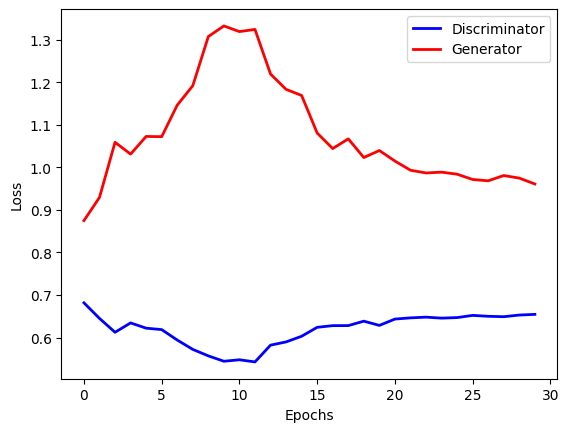

In [18]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
